# Self-Supervised Single-Image (Monocular) Depth-Estimation

CS 484: Computational Vision

By: Matthew Lam

Email: m39lam@uwaterloo.ca

# Abstract

This notebook explores self-supervised monocular depth estimation networks proposed by Godard et al. in their 2017 paper, "Unsupervised Monocular Depth Estimation with Left-Right Consistency" (https://arxiv.org/pdf/1609.03677v3.pdf).
Most existing techniques treat depth prediction as a supervised learning problem, which requires large amounts of ground truth depth data for training. Deep learning for monocular depth estimation faces this same problem as semantic segmentation, where there is a lack of readily available and accurate ground truth due to cumbersome labelling, which impedes the application of deep learning to this problem. This paper proposes a self-supervised method with a unique loss function that allows the convolutional neural network to perform single-image depth estimation without a ground truth by replacing the explicit depth data during training with readily available binocular stereo images.  


The implementation follows the official "Monodepth" repository on GitHub (https://github.com/mrharicot/monodepth). This approach uses the model's architecture in the paper for the decoder and transfer learning using ResNet for the encoder with the KITTI dataset to extract features from the RGB image correlated with depth information to allow the network to estimate depth from a single image. The convolutional neural network gets trained to predict the disparity map between the left and right images using only the left image as input. The scene's depth gets reconstructed using the estimated disparity map and the camera's intrinsic (focal length and optical center) and extrinsic (position and orientation in the world coordinate system) parameters. The depth gets computed using the formula: 

$$Depth = \frac{(b \cdot f)}{d}$$

where b (baseline) is the distance between the two cameras, f is the camera's focal length, and d is the disparity of the corresponding point in the stereo pair. 

![picture](https://drive.google.com/uc?id=1fvOvlsz3TL3VW_51j32FCCcR4yF-eNgN)

During training, the network learns to predict both the left-to-right and right-to-left disparity maps, which enforces the consistency between the two disparity maps to reduce artifacts in the final image. Additionally, two ground truths are used during training, one for the left image and one for the right image, by creating synthesized images using the disparity map and the corresponding image as shown in the diagram above. The training loss consists of comparing the target images, synthesized images and disparity maps using photo-consistency (appearance matching) and disparity map regularization (disparity smoothness and left-right disparity consistency).




In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from tqdm import tqdm
import os
import random
import copy
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR = '/content/drive/My Drive'
TRAIN_DIR = ROOT_DIR + '/train_data'
VAL_DIR = ROOT_DIR + '/val_data'
TEST_DIR = ROOT_DIR + '/test_data'
IMAGES_DIR = ROOT_DIR + '/images'
WEIGHTS_DIR = ROOT_DIR + '/weights'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset and Transformations

The dataset samples a small subset of the KITTI dataset.

Training Set consists of 3318 left-right image pairs:
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0117/2011_09_26_drive_0117_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0001/2011_09_28_drive_0001_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0026/2011_09_29_drive_0026_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_30_drive_0034/2011_09_30_drive_0034_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0042/2011_10_03_drive_0042_sync.zip

Validation Set consists of 661 left-right image pairs:
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_28_drive_0045/2011_09_28_drive_0045_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_29_drive_0004/2011_09_29_drive_0004_sync.zip
* https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_30_drive_0016/2011_09_30_drive_0016_sync.zip

Test Set consists of 1 left-right image pairs:
* https://vision.middlebury.edu/stereo/data/scenes2021/data/chess1

The KITTI dataset images were downloaded and extracted from the links above and uploaded to Google Drive in the following file structure:
* /content/drive/My Drive
    * train_data
        * 2011_09_26_drive_0117
            * left_images
                * 0000000000.png
                * ...
            * right_images
                * 0000000000.png
                * ...
        * ...
    * val_data
        * 2011_09_28_drive_0045
            * left_images
                * 0000000000.png
                * ...
            * right_images
                * 0000000000.png
                * ...
        * ...

    * test_data
        * chess
            * left_images
                * chessL.png
            * right_images
                * chessR.png

Each of the dataloaders finds the images in the left_images and right_images folders under the associated parent folder under train_data, val_data and test_data respectively. 

Note: test_data only contains one left-right image pair used for testing the neural network. This test data comes from the 2021 mobile datasets for chess1 by Scharstein et al.


There are six different transformations that will be applied during training including: random flip, resizing to 256 x 512 (input size), random gamma shift, random brightness shift, random color shift or saturation. Resizing the image to a smaller size makes training faster. Note that other transformations like cropping doesn't make sense as the network is trying to construct disparity maps and requires the left and right images to be similar. 





In [ ]:
# Create joint transformations for a sample from the dataset.
# It is either a imL or (imL, imR).

class JointToTensor(object):
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            return tF.to_tensor(target[0]), tF.to_tensor(target[1])
        return tF.to_tensor(target)
    
class JointRandomFlip(object):
    def __call__(self, target):
        if random.random() > 0.5:
            if isinstance(target, list) or isinstance(target, tuple):
                return tF.hflip(target[0]), tF.hflip(target[1])
            return tF.hflip(target)
        return target
        
class JointResize(object):
    def __init__(self, size=(256, 512)):
        self.resize = transforms.Resize(size)
        
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            return self.resize(target[0]), self.resize(target[1])
        return self.resize(target)

class JointRandomGammaShift(object):
    def __init__(self, gamma_low=0.8, gamma_high=1.3):
        self.gamma_low = gamma_low
        self.gamma_high = gamma_high
        
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
            augL = target[0] ** random_gamma
            augR = target[1] ** random_gamma
            return augL, augR
        return target

class JointRandomBrightness(object):
    def __init__(self, brightness_low=0.5, brightness_high=2.0):
        self.brightness_low = brightness_low
        self.brightness_high = brightness_high

    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
            augL = target[0] * random_brightness
            augR = target[1] * random_brightness
            return augL, augR
        return target

class JointRandomColorShift(object):
    def __init__(self, color_low=0.8, color_high=1.2):
        self.color_low = color_low
        self.color_high = color_high
        
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            random_colors = np.random.uniform(self.color_low, self.color_high, 3)
            augL = target[0]
            augR = target[1]
            # Randomly shifts colors for each channel
            for i in range(3):
                augL[i, :, :] *= random_colors[i]
                augR[i, :, :] *= random_colors[i]

            return augL, augR
        return target

class JointSaturate(object):
    def __call__(self, target):
        if isinstance(target, list) or isinstance(target, tuple):
            augL = torch.clamp(target[0], 0, 1)
            augR = torch.clamp(target[1], 0, 1)
            return augL, augR
        return target

In [ ]:
# Data Transformations
# Only augment randomized resizing, gamma shifts, brightness, color shift, saturate 
# and flipping during training.
train_transforms = transforms.Compose([
                              JointToTensor(), 
                              JointResize(), 
                              JointRandomGammaShift(),
                              JointRandomBrightness(),
                              JointRandomColorShift(), 
                              JointSaturate(),
                              JointRandomFlip()])

val_transforms = transforms.Compose([
                              JointToTensor(), 
                              JointResize()])

test_transforms = transforms.Compose([
                              JointToTensor(), 
                              JointResize()])

In [ ]:
class KITTIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Creates a dataset.
        Args:
            root_dir (string): root directory of the KITTI Dataset
            transforms: A transform that takes in either a imL or a (imL, imR) 
                tuple and returns a transformed version.
        """
        self.transform = transform
        self.imagesL = self.sortFilenames(os.path.join(root_dir, 'left_images'))
        self.imagesR = self.sortFilenames(os.path.join(root_dir, 'right_images'))
        assert len(self.imagesL) == len(self.imagesR)
        
    def __len__(self):
        return len(self.imagesL)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): corresponding index of an image in the dataset.
        """
        imL = Image.open(self.imagesL[idx])
        imR = Image.open(self.imagesR[idx])
        
        if self.transform:
            return self.transform((imL, imR))
        return imL, imR
    
    def sortFilenames(self, dir):
        """
        Args:
            dir (str): directory where the file names are sorted
        """
        return sorted([os.path.join(dir, file) for file in os.listdir(dir)])

In [ ]:
# Generates the training dataset and dataloader
train_datasets = []
for data_dir in os.listdir(TRAIN_DIR):
    train_dataset = KITTIDataset(os.path.join(TRAIN_DIR, data_dir), train_transforms)
    train_datasets.append(train_dataset)
train_dataset = ConcatDataset(train_datasets)
print('Training dataset with', len(train_dataset), 'images')
train_loader = DataLoader(train_dataset, batch_size=24, num_workers=4, shuffle=True)

# Generates the validation dataset and dataloader
val_datasets = []
for data_dir in os.listdir(VAL_DIR):
    val_dataset = KITTIDataset(os.path.join(VAL_DIR, data_dir), val_transforms)
    val_datasets.append(val_dataset)
val_dataset = ConcatDataset(val_datasets)
print('Validation dataset with', len(val_dataset), 'images')
val_loader = DataLoader(val_dataset, batch_size=24, num_workers=4, shuffle=True)

# Generates the test dataset and dataloader
test_datasets = []
for data_dir in os.listdir(TEST_DIR):
    test_dataset = KITTIDataset(os.path.join(TEST_DIR, data_dir), test_transforms)
    test_datasets.append(test_dataset)
test_dataset = ConcatDataset(test_datasets)
print('Validation dataset with', len(test_dataset), 'images')
test_loader = DataLoader(test_dataset, batch_size=24, num_workers=4, shuffle=True)

Training dataset with 3318 images
Validation dataset with 661 images
Validation dataset with 1 images


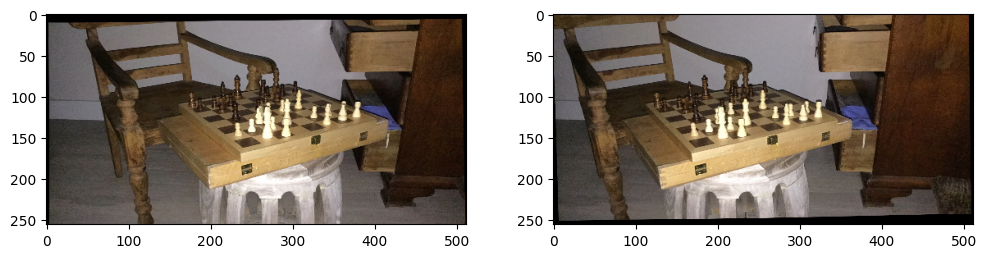

In [ ]:
imL, imR = test_loader.dataset[0]
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(imL.permute(1, 2, 0))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(imR.permute(1, 2, 0))

# Monocular Depth Loss Function

The proposed loss function is composed of the photo-consistency loss (appearance matching) and disparity map regularization loss (disparity smoothness and left-right disparity consistency). 

The appearance matching loss $C_{ap}$ compares the reconstructed image with the original image using SSIM (structural similarity index measure) and L1 norm. 

$$C_{ap} = \frac{1}{N} \sum_{ij} \alpha \frac{1-SSIM(I_{ij}\tilde{I_{ij}})}{2} + (1-\alpha) \|I_{ij}- \tilde{I_{ij}} \|$$

Here, N is the number of pixels, $I_{ij}$ is the input image, $\tilde{I_{ij}}$ is the reconstructed image and $\alpha = 0.85$.

The disparity smoothness loss $C_{ds}$ uses an L1 penalty on the disparity gradients to encourage local smoothness and to prevent edge discontunity from image gradients.

$$C_{ds} = \frac{1}{N} \sum_{ij} |\partial_x d_{ij}|e^{-\| \partial_x I_{ij}\|} + |\partial_y d_{ij}|e^{-\| \partial_y I_{ij}\|}$$

Here, $d_{ij}$ is the disparity, $\partial d_{ij}$ is the disparity gradient, N is the number of pixels, $I_{ij}$ is the input image, and $\tilde{I_{ij}}$ is the reconstructed image.

The left-right disparity loss $C_{lr}$ uses L1 norm to encourage consistency between the left disparity map and the synthesized right disparity map.

$$C_{lr} = \frac{1}{N} \sum_{ij} |d^l_{ij}-d^r_{ij+d^l_{ij}}|$$

Here $d^l_{ij}$ is the left image disparity and $d^r_{ij+d^l_{ij}}$ is the right image disparity.

The overall loss is expressed as:

$$C_s = \alpha_{ap}(C^l_ap+C^r_ap) + \alpha_{ds}(C^l_ds+C^r_ds) + \alpha_{lr}(C^l_lr+C^r_lr)$$

Here, $\alpha_{ap}, \alpha_{ds}, \alpha_{lr}$ are the weighting variable for each type of loss. For the neural net, $\alpha_{ap} = \alpha_{lr} = 1$ and $\alpha_{ds} = \frac{1}{r}$ where $r$ is the downscaling factor for each disparity map.

In [ ]:
class MonocularDepthLoss(nn.modules.Module):
    def __init__(self, device='cpu', alphaAP = 1, alphaDS = 1, alphaLR = 1):
        super(MonocularDepthLoss, self).__init__()

        self.alphaAP = alphaAP
        self.alphaDS = alphaDS
        self.alphaLR = alphaLR
    
    def scaleImg(self, img):
        """
        Scales the images using bilinear interpolation by a factor of 1, 0.5, 
        0.25, and 0.125.

        Args:
            img: input image
        Return:
            (list): list of images that are scaled
        """
        images = []
        _, _, h, w = img.size()

        for s in [1, 0.5, 0.25, 0.125]:
            newSize = (int(h * s), int(w * s))
            scaledImg = F.interpolate(img, size=newSize, mode='bilinear', align_corners=True)
            images.append(scaledImg)
        return images

    def generateImageFromDmap(self, imgL, left2RightDmap):
        """
        Generates a right image given a left image and a left to right disparity map
        args:
            imgL: tensor of size [batchSize, channels, height, width]
            left2RightDmap: tensor of size [batchSize, channels, height, width]
        Return:
            (tensor): generated img using a disparity map
        """
        batchSize, channels, h, w = imgL.shape
        left2RightDmap = left2RightDmap[:, 0, :, :].to(device)
        
        # Normalize pixel positions
        x = torch.linspace(0, 1, h)
        y = torch.linspace(0, 1, w)
        meshy, meshx = torch.meshgrid(x, y)
        meshx = meshx.repeat(batchSize, 1, 1).to(device)
        meshy = meshy.repeat(batchSize, 1, 1).to(device)
        
        newR = meshx + left2RightDmap
        flowfield = torch.stack((newR, meshy), dim=3).type_as(imgL)
        grid = 2 * flowfield - 1
        return F.grid_sample(imgL, grid, mode='bilinear', padding_mode='zeros')

    def appearanceMatchingLoss(self, x, y, alpha=0.85):
        """
        Compares the reconstructed image with the original image using SSIM 
        (structural similarity index measure). 
        Args:
            dmap: disparity map
            img: input image
            alpha: float from 0-1 for SSIM
        Return:
            (float): appearance matching loss
        """
        # This SSIM used was adapted from 
        # https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L91
        c1 = 0.01
        c2 = 0.03

        muX = nn.AvgPool2d(3, 1)(x)
        muY = nn.AvgPool2d(3, 1)(y)

        sigmaX = nn.AvgPool2d(3, 1)(x * x) - (muX * muX)
        sigmaY = nn.AvgPool2d(3, 1)(y * y) - (muY * muY)
        sigmaXY = nn.AvgPool2d(3, 1)(x * y) - (muX * muY)

        SSIM_n = (2 * muX * muY + c1*c1) * (2 * sigmaXY + c2*c2)
        SSIM_d = (muX * muX + muY * muY + c1*c1) * (sigmaX + sigmaY + c2*c2)
        SSIM = SSIM_n / SSIM_d

        ssim = torch.clamp((1 - SSIM) / 2, 0, 1)
        ssim_loss = alpha * torch.mean(ssim)
        mae = (1 - alpha) * torch.mean(torch.abs(x - y))

        return ssim_loss + mae

    def disparitySmoothnessLoss(self, dmap, img):
        """
        Penalizes gradient discontinuities. Uses weights from image gradients 
        to prevent edge discontunity penalization.
        Args:
            dmap: disparity map
            img: input image
        Return:
            (float): disparity smoothness loss
        """
        dmapDX = F.pad(dmap, (0, 1, 0, 0), mode="replicate")
        dmapDX = torch.abs(dmapDX[:, :, :, :-1] - dmapDX[:, :, :, 1:])
        dmapDY = F.pad(dmap, (0, 0, 0, 1), mode="replicate")
        dmapDY = torch.abs(dmapDY[:, :, :-1, :] - dmapDY[:, :, 1:, :])

        imgDX = F.pad(img, (0, 1, 0, 0), mode="replicate")
        imgDX = torch.abs(imgDX[:, :, :, :-1] - imgDX[:, :, :, 1:])
        imgDY = F.pad(img, (0, 0, 0, 1), mode="replicate")
        imgDY = torch.abs(imgDY[:, :, :-1, :] - imgDY[:, :, 1:, :])

        dslDX = dmapDX * torch.exp(-torch.mean(imgDX, 1, keepdim=True))
        dslDY = dmapDY * torch.exp(-torch.mean(imgDY, 1, keepdim=True))
        return torch.mean(dslDX + dslDY)

    def LRConsistencyLoss(self, dmapL, dmapR):
        """
        Uses MAE to encourage consistency between the left disparity map and the
        synthesized right disparity map.
        Args:
            dmapL: left disparity map
            dmapR: right disparity map
        Return:
            (float): left-right consistency loss
        """
        dmapSynthR = self.generateImageFromDmap(dmapR, -dmapL)
        dmapSynthL = self.generateImageFromDmap(dmapL, dmapR)
        maeSynthR = torch.mean(torch.abs(dmapSynthR  - dmapL))
        maeSynthL = torch.mean(torch.abs(dmapSynthL  - dmapR))
        return maeSynthL + maeSynthR
    
    def __call__(self, input, target):
        """
        Calculates the total loss using appearance matching, disparity 
        smoothness, and left-right consistency.
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): monocular depth loss
        """
        
        imL, imR = target
        imScaledL = self.scaleImg(imL)
        imScaledR = self.scaleImg(imR)

        dmapL = [disp[:, 0, :, :].unsqueeze(1) for disp in input]
        dmapR = [disp[:, 1, :, :].unsqueeze(1) for disp in input]
        
        # Dmap has values [0,0.3]. Need to shift LEFT (negative) when using the left dmap
        imReconstructedL = [self.generateImageFromDmap(im, -disp) for im, disp in zip(imScaledR, dmapL)]
        imReconstructedR = [self.generateImageFromDmap(im, disp) for im, disp in zip(imScaledL, dmapR)]
        
        # Appearance Matching Loss
        apLoss = []
        for i in range(len(imReconstructedL)):
            apLossL = self.appearanceMatchingLoss(imReconstructedL[i], imScaledL[i])
            apLossR = self.appearanceMatchingLoss(imReconstructedR[i], imScaledR[i])
            apLoss.append(apLossL)
            apLoss.append(apLossR)
        self.lossAP = self.alphaAP * sum(apLoss)
        
        # Disparity Smoothness Loss
        dsLoss = []
        for i in range(4):
            dsLoss.append(self.disparitySmoothnessLoss(dmapL[i], dmapR[i]) / 2 ** i)
            dsLoss.append(self.disparitySmoothnessLoss(dmapR[i], dmapL[i]) / 2 ** i)
        self.lossDS = self.alphaDS * sum(dsLoss)
        
        # Left Right Consistency Loss
        lrLoss = []
        for L, R in zip(dmapL, dmapR):
            lrLoss.append(self.LRConsistencyLoss(L, R))
        self.lossLR = self.alphaLR * sum(lrLoss)
        
        return self.lossAP + self.lossDS + self.lossLR

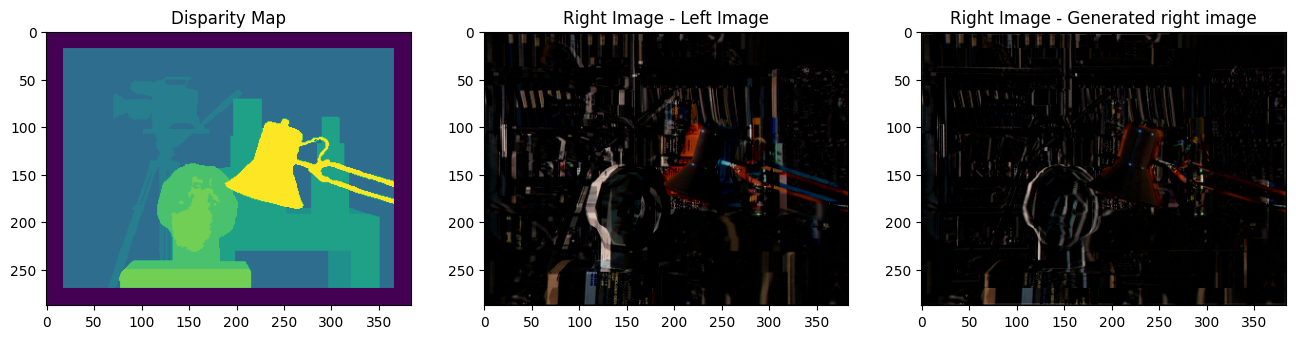

In [ ]:
# Import images from class
imL = tF.to_tensor(image.imread(IMAGES_DIR + "/sceneL.ppm"))
imR = tF.to_tensor(image.imread(IMAGES_DIR + "/sceneR.ppm"))
imGT = torch.from_numpy(image.imread(IMAGES_DIR + "/truedisp.pgm") / 16)
imGT = imGT / imGT.shape[0]

# Generate image using disparity map
mdl = MonocularDepthLoss()
imGenerated = mdl.generateImageFromDmap(imL[None], imGT[None, None])

# Calculate disparities
dispRL = (imR - imL).permute(1, 2, 0)
dispRGen = (imR - imGenerated[0]).permute(1, 2, 0) 

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,3,1)
plt.title('Disparity Map')
ax.imshow(imGT)

ax = fig.add_subplot(1,3,2)
plt.title('Right Image - Left Image')
ax.imshow(dispRL)

ax = fig.add_subplot(1,3,3)
plt.title('Right Image - Generated right image')
ax.imshow(dispRGen)

In [ ]:
# Used to verify the correctness of the loss functions
print("Appearance Matching Loss btwn right image and generated image:")
print(mdl.appearanceMatchingLoss(imR[None], imGenerated))
print("Disparity Smoothness Loss btwn left image (dmap) and ground truth (img):")
print(mdl.disparitySmoothnessLoss(imGT[None, None], imL[None]))
print("Disparity Smoothness Loss btwn ground truth (dmap) and left image (img):")
print(mdl.disparitySmoothnessLoss(imL[None], imGT[None, None]))
print("Left-Right Consistency Loss btwn two ground truths:")
print(mdl.LRConsistencyLoss(imGT[None, None], imGT[None, None]))

# Test the loss
test = [torch.stack((dmap[:,0], dmap[:,0]), dim=1) for dmap in mdl.scaleImg(imGT[None, None])]
print("Test Image Shape: ", test[0].shape)
print("Test Prediction: ", mdl(test, [imL[None], imR[None]]))

Appearance Matching Loss btwn right image and generated image:
tensor(0.1623)
Disparity Smoothness Loss btwn left image (dmap) and ground truth (img):
tensor(0.0006, dtype=torch.float64)
Disparity Smoothness Loss btwn ground truth (dmap) and left image (img):
tensor(0.0545, dtype=torch.float64)
Left-Right Consistency Loss btwn two ground truths:
tensor(0.0042, dtype=torch.float64)
Test Image Shape:  torch.Size([1, 2, 288, 384])
Test Prediction:  tensor(1.3256, dtype=torch.float64)


# The Network

The architecture of monocular depth estimation follows a conventional encoder-decoder framework, where the encoder uses ResNet18. This slightly differs from the implementation details from the paper as the authors use ResNet50 for the encoder. Four skip connections from the ResNet18's encoder are used to enhance the resolution of the output. The decoder estimates diparities at four resolutions, each having a double scale in resolution. The network provides two disparity map outputs, left-to-right and right-to-left. The kernel size, stride, number of input and output channels for each layer follow the diagram below from the paper by Godard et al. 

![picture](https://drive.google.com/uc?id=1OauDEb1vBC6aw0Hn7OrhPCegEpUbkbGZ)

In [ ]:
# Helper nn.Modules adapted from 
# https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L161
class iconv(nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size, stride):
        super(iconv, self).__init__()
        padding = int(np.floor((kernel_size-1)/2))
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_layers, out_layers, kernel_size, stride, padding),
            nn.BatchNorm2d(out_layers),
            nn.ELU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)

class upconv(nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.layers = iconv(in_layers, out_layers, kernel_size, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.layers(x)

class disp(nn.Module):
    def __init__(self, in_layers):
        super(disp, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_layers, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Maximum disparity of 1/3 the image
        return 0.3 * self.layers(x)

In [ ]:
# Network adapted from:
# https://github.com/mrharicot/monodepth/blob/master/monodepth_model.py#L171

# Note: TorchVision's Resnet18 slightly differs that the one used in the paper
# as it has faster downsampling, hence fewer number of encoding layers.

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        # Used for graphing the network's training results
        self.loss_graph = []
        self.ap = []
        self.lr = []
        self.ds = []
        
        # Encoding layers
        # Transfer learning for faster training using the pretrained weights 
        # from Resnet18. 
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        ds5 = nn.Sequential(
                    nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
        # Additional layers 5 and 6 for the encoder to follow similarly to the 
        # paper as the resnet block goes from depth 512 -> 512.
        self.layer5 = models.resnet.BasicBlock(512, 512, stride=(2, 2), downsample=ds5)
        self.layer6 = models.resnet.BasicBlock(512, 512)
        
        # Decoding layers
        self.upconv1 = upconv(32, 16, 3, 2)
        self.upconv2 = upconv(64, 32, 3, 2)
        self.upconv3 = upconv(128, 64, 3, 1)
        self.upconv4 = upconv(256, 128, 3, 2)
        self.upconv5 = upconv(512, 256, 3, 2)
        self.upconv6 = upconv(512, 512, 3, 2)
        self.upconv7 = upconv(512, 512, 3, 2)

        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.iconv4 = iconv(64 + 128, 128, 3, 1)
        self.iconv5 = iconv(128 + 256, 256, 3, 1)
        self.iconv6 = iconv(256 + 512, 512, 3, 1)
        self.iconv7 = iconv(512 + 512, 512, 3, 1)


        self.disp1_layer = disp(16)
        self.disp2_layer = disp(32)
        self.disp3_layer = disp(64)
        self.disp4_layer = disp(128)

    def forward(self, imL):
        """
        Args:
            imL: left image
        Return:
            disp1: disparity map
            [disp1, disp2, disp3, disp4]: disparity maps used for loss function
        """

        # Encoder
        skip1 = self.resnet.conv1(imL) 
        skip1_ = self.resnet.bn1(skip1)
        skip1_ = self.resnet.relu(skip1_)
        skip2 = self.resnet.maxpool(skip1_)
        skip3 = self.resnet.layer1(skip2)
        skip4 = self.resnet.layer2(skip3)
        skip5 = self.resnet.layer3(skip4)
        skip6 = self.resnet.layer4(skip5)
        skip7 = self.layer5(skip6) 
        x = self.layer6(skip7)

        # Decoder       
        upconv7 = self.upconv7(x)
        iconv7 = self.iconv7(torch.cat((upconv7, skip6), 1))
        
        upconv6 = self.upconv6(iconv7)
        iconv6 = self.iconv6(torch.cat((upconv6, skip5), 1))

        upconv5 = self.upconv5(iconv6)
        iconv5 = self.iconv5(torch.cat((upconv5, skip4), 1))

        upconv4 = self.upconv4(iconv5)
        iconv4 = self.iconv4(torch.cat((upconv4, skip3), 1))
        disp4 = self.disp4_layer(iconv4)
        udisp4 = nn.functional.interpolate(disp4, scale_factor=1, mode='bilinear', align_corners=True)
        disp4 = nn.functional.interpolate(disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        iconv3 = self.iconv3(torch.cat((upconv3, skip2, udisp4), 1))
        disp3 = self.disp3_layer(iconv3)
        udisp3 = nn.functional.interpolate(disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        iconv2 = self.iconv2(torch.cat((upconv2, skip1, udisp3), 1))
        disp2 = self.disp2_layer(iconv2)
        udisp2 = nn.functional.interpolate(disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        iconv1 = self.iconv1(torch.cat((upconv1, udisp2), 1))
        disp1 = self.disp1_layer(iconv1)

        return [disp1, disp2, disp3, disp4]
    
    def learn(self, train_loader, epochs=10, optimizer=None, loss_fcn=None):
        """
        Train the network on the dataset delivered by the dataloader train_dl.

        Args:
            train_loader: data loader with the training set
            epochs: number of epochs to train
            optimizer: PyTorch optimizer function
            loss_fcn: PyTorch or custom loss function 
        """
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            for i, data in enumerate(train_loader):
            
                imL, imR = data
                imL = imL.to(device)
                imR = imR.to(device)
                
                output = self(imL)
                loss = loss_fcn(output, [imL, imR])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Used for graphing the loss 
            self.loss_graph.append(loss.item())
            self.ap.append(loss_fcn.lossAP.item())
            self.lr.append(loss_fcn.lossLR.item())
            self.ds.append(loss_fcn.lossDS.item())
            print("Epoch: {} Loss: {}".format(epoch, loss))
        

# Visualing a Sample using the Untrained Network



In [ ]:
def plotDispResults(net, dataset, i, plot=True):
    """
    Plots the original left and right image. Also plots the left and right 
    synthesized disparity.
    Args:
        input [disp1, disp2, disp3, disp4]
        target [left, right]
    Return:
        dmap: disparity map from the network
    """
    net.eval()
    imL, imR = dataset[i]
    dmap = net.forward(imL[None].to(device))[0].to('cpu').detach()
    dmapL, dmapR = dmap[:,0,:,:].unsqueeze(1), dmap[:,1,:,:].unsqueeze(1)
    
    if plot:
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,2,1)
        plt.title('Left Image')
        ax.imshow(imL.permute(1, 2, 0))
        ax = fig.add_subplot(2,2,2)
        plt.title('Right Image')
        ax.imshow(imR.permute(1, 2, 0))
        ax = fig.add_subplot(2,2,3)
        plt.title('Left Synthesized Dmap')
        ax.imshow(dmapL[0][0])
        ax = fig.add_subplot(2,2,4)
        plt.title('Right Synthesized Dmap')
        ax.imshow(dmapR[0][0])
    
    return dmap

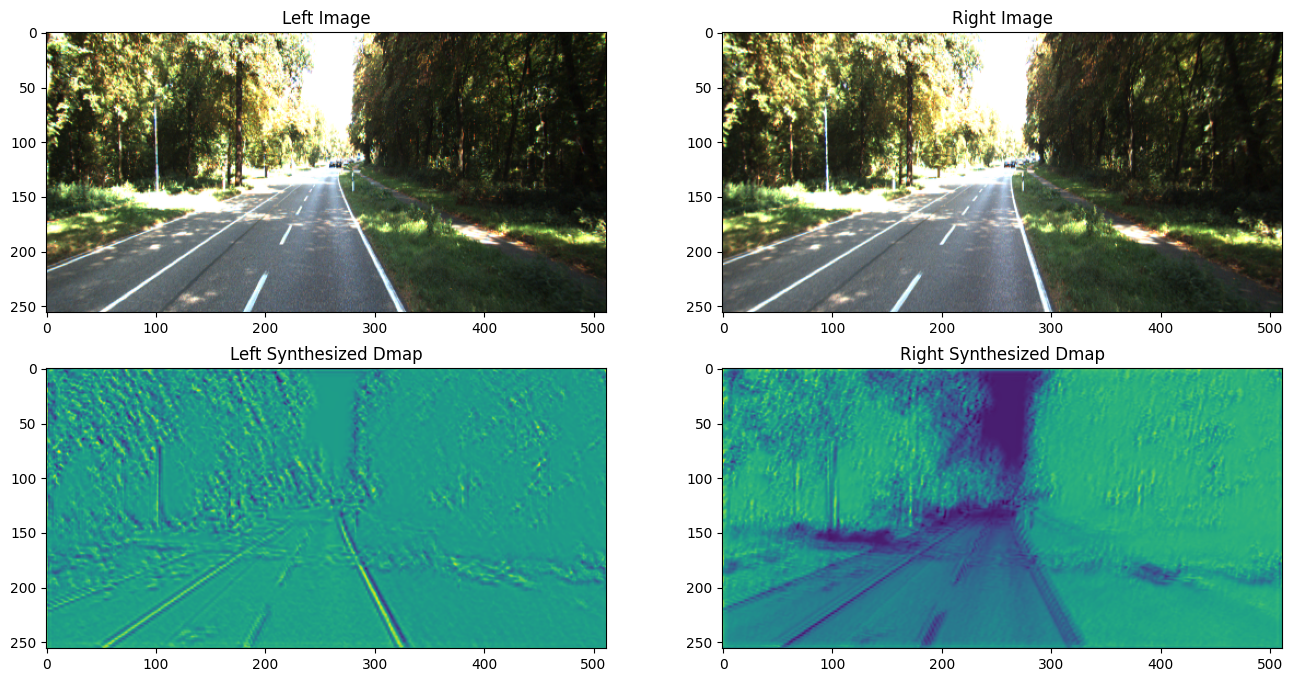

In [ ]:
# Test the untrained network on some sample images
untrained_net = MyNet().eval().to(device)
dmap = plotDispResults(untrained_net, val_dataset, 0)

# Fitting the Network using a Single Image Pair

To ensure the correctness of the network's architecture with the custom loss function, the network will be fitted with a single left-right image pair from the test_loader. 



In [ ]:
test_net = MyNet().to(device)

In [ ]:
# test_net.load_state_dict(torch.load(WEIGHTS_DIR+"/test_weights1"))
# test_net.eval()

In [ ]:
%%time
loss_fcn = MonocularDepthLoss(device).to(device)
optimizer = torch.optim.Adam(test_net.parameters(), lr=0.01)
print("Starting Training with #images: ", len(test_loader) * test_loader.batch_size)
test_net.learn(test_loader, epochs=1000, optimizer=optimizer, loss_fcn=loss_fcn)

Starting Training with #images:  24


  0%|          | 1/1000 [00:00<12:09,  1.37it/s]

Epoch: 0 Loss: 3.6926310062408447


  0%|          | 2/1000 [00:01<11:04,  1.50it/s]

Epoch: 1 Loss: 3.4100282192230225


  0%|          | 3/1000 [00:01<10:52,  1.53it/s]

Epoch: 2 Loss: 3.2772605419158936


  0%|          | 4/1000 [00:02<10:46,  1.54it/s]

Epoch: 3 Loss: 3.092691421508789


  0%|          | 5/1000 [00:03<10:38,  1.56it/s]

Epoch: 4 Loss: 3.0437369346618652


  1%|          | 6/1000 [00:03<10:32,  1.57it/s]

Epoch: 5 Loss: 2.963690996170044


  1%|          | 7/1000 [00:04<10:27,  1.58it/s]

Epoch: 6 Loss: 2.914308547973633


  1%|          | 8/1000 [00:05<10:19,  1.60it/s]

Epoch: 7 Loss: 2.870572090148926


  1%|          | 9/1000 [00:05<10:14,  1.61it/s]

Epoch: 8 Loss: 2.838268756866455


  1%|          | 10/1000 [00:06<10:13,  1.61it/s]

Epoch: 9 Loss: 2.8039252758026123


  1%|          | 11/1000 [00:07<10:24,  1.58it/s]

Epoch: 10 Loss: 2.7626256942749023


  1%|          | 12/1000 [00:07<10:21,  1.59it/s]

Epoch: 11 Loss: 2.745992660522461


  1%|▏         | 13/1000 [00:08<10:18,  1.60it/s]

Epoch: 12 Loss: 2.717454195022583


  1%|▏         | 14/1000 [00:08<10:32,  1.56it/s]

Epoch: 13 Loss: 2.69687557220459


  2%|▏         | 15/1000 [00:09<10:27,  1.57it/s]

Epoch: 14 Loss: 2.6828908920288086


  2%|▏         | 16/1000 [00:10<10:23,  1.58it/s]

Epoch: 15 Loss: 2.663536787033081


  2%|▏         | 17/1000 [00:11<12:07,  1.35it/s]

Epoch: 16 Loss: 2.6348283290863037


  2%|▏         | 18/1000 [00:12<13:41,  1.20it/s]

Epoch: 17 Loss: 2.6181752681732178


  2%|▏         | 19/1000 [00:13<14:48,  1.10it/s]

Epoch: 18 Loss: 2.603023052215576


  2%|▏         | 20/1000 [00:14<15:02,  1.09it/s]

Epoch: 19 Loss: 2.583250045776367


  2%|▏         | 21/1000 [00:15<14:54,  1.10it/s]

Epoch: 20 Loss: 2.570953845977783


  2%|▏         | 22/1000 [00:15<13:44,  1.19it/s]

Epoch: 21 Loss: 2.553203582763672


  2%|▏         | 23/1000 [00:16<12:39,  1.29it/s]

Epoch: 22 Loss: 2.5409655570983887


  2%|▏         | 24/1000 [00:17<11:56,  1.36it/s]

Epoch: 23 Loss: 2.5281522274017334


  2%|▎         | 25/1000 [00:17<11:28,  1.42it/s]

Epoch: 24 Loss: 2.5174899101257324


  3%|▎         | 26/1000 [00:18<11:00,  1.47it/s]

Epoch: 25 Loss: 2.5092482566833496


  3%|▎         | 27/1000 [00:18<10:42,  1.51it/s]

Epoch: 26 Loss: 2.4902327060699463


  3%|▎         | 28/1000 [00:19<10:35,  1.53it/s]

Epoch: 27 Loss: 2.4894158840179443


  3%|▎         | 29/1000 [00:20<10:32,  1.53it/s]

Epoch: 28 Loss: 2.477825403213501


  3%|▎         | 30/1000 [00:20<10:31,  1.54it/s]

Epoch: 29 Loss: 2.47448992729187


  3%|▎         | 31/1000 [00:21<10:28,  1.54it/s]

Epoch: 30 Loss: 2.4479408264160156


  3%|▎         | 32/1000 [00:22<10:19,  1.56it/s]

Epoch: 31 Loss: 2.4405369758605957


  3%|▎         | 33/1000 [00:22<10:21,  1.56it/s]

Epoch: 32 Loss: 2.4467599391937256


  3%|▎         | 34/1000 [00:23<10:18,  1.56it/s]

Epoch: 33 Loss: 2.424565315246582


  4%|▎         | 35/1000 [00:24<10:13,  1.57it/s]

Epoch: 34 Loss: 2.428327798843384


  4%|▎         | 36/1000 [00:24<10:12,  1.57it/s]

Epoch: 35 Loss: 2.4055633544921875


  4%|▎         | 37/1000 [00:25<10:11,  1.57it/s]

Epoch: 36 Loss: 2.418508291244507


  4%|▍         | 38/1000 [00:26<11:28,  1.40it/s]

Epoch: 37 Loss: 2.389695167541504


  4%|▍         | 39/1000 [00:27<12:27,  1.29it/s]

Epoch: 38 Loss: 2.3881947994232178


  4%|▍         | 40/1000 [00:28<13:05,  1.22it/s]

Epoch: 39 Loss: 2.3633852005004883


  4%|▍         | 41/1000 [00:28<13:22,  1.19it/s]

Epoch: 40 Loss: 2.369546413421631


  4%|▍         | 42/1000 [00:29<12:19,  1.29it/s]

Epoch: 41 Loss: 2.352506637573242


  4%|▍         | 43/1000 [00:30<11:32,  1.38it/s]

Epoch: 42 Loss: 2.3309645652770996


  4%|▍         | 44/1000 [00:30<11:04,  1.44it/s]

Epoch: 43 Loss: 2.3292832374572754


  4%|▍         | 45/1000 [00:31<10:40,  1.49it/s]

Epoch: 44 Loss: 2.310227155685425


  5%|▍         | 46/1000 [00:32<10:24,  1.53it/s]

Epoch: 45 Loss: 2.3030447959899902


  5%|▍         | 47/1000 [00:32<10:17,  1.54it/s]

Epoch: 46 Loss: 2.2922489643096924


  5%|▍         | 48/1000 [00:33<10:18,  1.54it/s]

Epoch: 47 Loss: 2.290407657623291


  5%|▍         | 49/1000 [00:33<10:12,  1.55it/s]

Epoch: 48 Loss: 2.2804369926452637


  5%|▌         | 50/1000 [00:34<10:02,  1.58it/s]

Epoch: 49 Loss: 2.272974729537964


  5%|▌         | 51/1000 [00:35<10:02,  1.57it/s]

Epoch: 50 Loss: 2.271124839782715


  5%|▌         | 52/1000 [00:35<09:59,  1.58it/s]

Epoch: 51 Loss: 2.276325225830078


  5%|▌         | 53/1000 [00:36<09:55,  1.59it/s]

Epoch: 52 Loss: 2.262303113937378


  5%|▌         | 54/1000 [00:37<09:56,  1.59it/s]

Epoch: 53 Loss: 2.2566678524017334


  6%|▌         | 55/1000 [00:37<09:56,  1.58it/s]

Epoch: 54 Loss: 2.237356662750244


  6%|▌         | 56/1000 [00:38<09:58,  1.58it/s]

Epoch: 55 Loss: 2.2300374507904053


  6%|▌         | 57/1000 [00:39<10:00,  1.57it/s]

Epoch: 56 Loss: 2.2160637378692627


  6%|▌         | 58/1000 [00:39<11:22,  1.38it/s]

Epoch: 57 Loss: 2.2135651111602783


  6%|▌         | 59/1000 [00:40<12:06,  1.30it/s]

Epoch: 58 Loss: 2.2318105697631836


  6%|▌         | 60/1000 [00:41<12:34,  1.25it/s]

Epoch: 59 Loss: 2.246229648590088


  6%|▌         | 61/1000 [00:42<12:59,  1.21it/s]

Epoch: 60 Loss: 2.198093891143799


  6%|▌         | 62/1000 [00:43<12:01,  1.30it/s]

Epoch: 61 Loss: 2.215806722640991


  6%|▋         | 63/1000 [00:43<11:21,  1.38it/s]

Epoch: 62 Loss: 2.2204883098602295


  6%|▋         | 64/1000 [00:44<10:51,  1.44it/s]

Epoch: 63 Loss: 2.1871280670166016


  6%|▋         | 65/1000 [00:45<12:25,  1.25it/s]

Epoch: 64 Loss: 2.2295825481414795


  7%|▋         | 66/1000 [00:46<12:41,  1.23it/s]

Epoch: 65 Loss: 2.2012429237365723


  7%|▋         | 67/1000 [00:46<11:49,  1.32it/s]

Epoch: 66 Loss: 2.2137672901153564


  7%|▋         | 68/1000 [00:47<11:07,  1.40it/s]

Epoch: 67 Loss: 2.1700236797332764


  7%|▋         | 69/1000 [00:48<10:46,  1.44it/s]

Epoch: 68 Loss: 2.192301034927368


  7%|▋         | 70/1000 [00:48<10:24,  1.49it/s]

Epoch: 69 Loss: 2.162686586380005


  7%|▋         | 71/1000 [00:49<10:16,  1.51it/s]

Epoch: 70 Loss: 2.1755661964416504


  7%|▋         | 72/1000 [00:50<10:05,  1.53it/s]

Epoch: 71 Loss: 2.1605098247528076


  7%|▋         | 73/1000 [00:50<10:01,  1.54it/s]

Epoch: 72 Loss: 2.1500465869903564


  7%|▋         | 74/1000 [00:51<09:57,  1.55it/s]

Epoch: 73 Loss: 2.160707712173462


  8%|▊         | 75/1000 [00:52<09:46,  1.58it/s]

Epoch: 74 Loss: 2.1123154163360596


  8%|▊         | 76/1000 [00:52<09:50,  1.57it/s]

Epoch: 75 Loss: 2.1357240676879883


  8%|▊         | 77/1000 [00:53<10:58,  1.40it/s]

Epoch: 76 Loss: 2.106369972229004


  8%|▊         | 78/1000 [00:54<11:41,  1.31it/s]

Epoch: 77 Loss: 2.1095950603485107


  8%|▊         | 79/1000 [00:55<12:10,  1.26it/s]

Epoch: 78 Loss: 2.087637186050415


  8%|▊         | 80/1000 [00:56<12:27,  1.23it/s]

Epoch: 79 Loss: 2.085580348968506


  8%|▊         | 81/1000 [00:56<11:47,  1.30it/s]

Epoch: 80 Loss: 2.0679233074188232


  8%|▊         | 82/1000 [00:57<11:07,  1.38it/s]

Epoch: 81 Loss: 2.0634021759033203


  8%|▊         | 83/1000 [00:58<10:41,  1.43it/s]

Epoch: 82 Loss: 2.054436683654785


  8%|▊         | 84/1000 [00:58<10:22,  1.47it/s]

Epoch: 83 Loss: 2.0549590587615967


  8%|▊         | 85/1000 [00:59<10:03,  1.52it/s]

Epoch: 84 Loss: 2.048464059829712


  9%|▊         | 86/1000 [00:59<09:59,  1.53it/s]

Epoch: 85 Loss: 2.0364761352539062


  9%|▊         | 87/1000 [01:00<09:50,  1.55it/s]

Epoch: 86 Loss: 2.037947177886963


  9%|▉         | 88/1000 [01:01<09:48,  1.55it/s]

Epoch: 87 Loss: 2.0345470905303955


  9%|▉         | 89/1000 [01:01<09:47,  1.55it/s]

Epoch: 88 Loss: 2.019399404525757


  9%|▉         | 90/1000 [01:02<09:42,  1.56it/s]

Epoch: 89 Loss: 2.0106959342956543


  9%|▉         | 91/1000 [01:03<09:35,  1.58it/s]

Epoch: 90 Loss: 2.0088307857513428


  9%|▉         | 92/1000 [01:03<09:30,  1.59it/s]

Epoch: 91 Loss: 1.9868797063827515


  9%|▉         | 93/1000 [01:04<09:32,  1.58it/s]

Epoch: 92 Loss: 1.9689162969589233


  9%|▉         | 94/1000 [01:05<09:29,  1.59it/s]

Epoch: 93 Loss: 1.9654144048690796


 10%|▉         | 95/1000 [01:05<09:26,  1.60it/s]

Epoch: 94 Loss: 1.9643146991729736


 10%|▉         | 96/1000 [01:06<09:25,  1.60it/s]

Epoch: 95 Loss: 1.9630190134048462


 10%|▉         | 97/1000 [01:07<10:44,  1.40it/s]

Epoch: 96 Loss: 1.969592571258545


 10%|▉         | 98/1000 [01:08<11:32,  1.30it/s]

Epoch: 97 Loss: 1.9282116889953613


 10%|▉         | 99/1000 [01:08<12:12,  1.23it/s]

Epoch: 98 Loss: 1.9275096654891968


 10%|█         | 100/1000 [01:09<12:34,  1.19it/s]

Epoch: 99 Loss: 1.9082183837890625


 10%|█         | 101/1000 [01:10<11:45,  1.27it/s]

Epoch: 100 Loss: 1.9265623092651367


 10%|█         | 102/1000 [01:11<11:05,  1.35it/s]

Epoch: 101 Loss: 1.9073700904846191


 10%|█         | 103/1000 [01:11<10:33,  1.42it/s]

Epoch: 102 Loss: 1.8957792520523071


 10%|█         | 104/1000 [01:12<10:13,  1.46it/s]

Epoch: 103 Loss: 1.8901913166046143


 10%|█         | 105/1000 [01:13<09:56,  1.50it/s]

Epoch: 104 Loss: 1.8795527219772339


 11%|█         | 106/1000 [01:13<09:50,  1.51it/s]

Epoch: 105 Loss: 1.8652890920639038


 11%|█         | 107/1000 [01:14<09:48,  1.52it/s]

Epoch: 106 Loss: 1.8549455404281616


 11%|█         | 108/1000 [01:14<09:35,  1.55it/s]

Epoch: 107 Loss: 1.8514337539672852


 11%|█         | 109/1000 [01:15<09:32,  1.56it/s]

Epoch: 108 Loss: 1.812600016593933


 11%|█         | 110/1000 [01:16<09:33,  1.55it/s]

Epoch: 109 Loss: 1.827987790107727


 11%|█         | 111/1000 [01:16<09:26,  1.57it/s]

Epoch: 110 Loss: 1.8062268495559692


 11%|█         | 112/1000 [01:17<09:23,  1.58it/s]

Epoch: 111 Loss: 1.8592793941497803


 11%|█▏        | 113/1000 [01:18<10:33,  1.40it/s]

Epoch: 112 Loss: 1.8400295972824097


 11%|█▏        | 114/1000 [01:19<11:04,  1.33it/s]

Epoch: 113 Loss: 1.7920303344726562


 12%|█▏        | 115/1000 [01:19<10:35,  1.39it/s]

Epoch: 114 Loss: 1.7921022176742554


 12%|█▏        | 116/1000 [01:20<11:25,  1.29it/s]

Epoch: 115 Loss: 1.793013572692871


 12%|█▏        | 117/1000 [01:21<11:53,  1.24it/s]

Epoch: 116 Loss: 1.7893295288085938


 12%|█▏        | 118/1000 [01:22<12:13,  1.20it/s]

Epoch: 117 Loss: 1.8140342235565186


 12%|█▏        | 119/1000 [01:23<12:39,  1.16it/s]

Epoch: 118 Loss: 1.7760462760925293


 12%|█▏        | 120/1000 [01:24<12:03,  1.22it/s]

Epoch: 119 Loss: 1.7636256217956543


 12%|█▏        | 121/1000 [01:24<11:12,  1.31it/s]

Epoch: 120 Loss: 1.793918490409851


 12%|█▏        | 122/1000 [01:25<10:37,  1.38it/s]

Epoch: 121 Loss: 1.754535436630249


 12%|█▏        | 123/1000 [01:26<10:09,  1.44it/s]

Epoch: 122 Loss: 1.7642487287521362


 12%|█▏        | 124/1000 [01:26<09:51,  1.48it/s]

Epoch: 123 Loss: 1.7889337539672852


 12%|█▎        | 125/1000 [01:27<09:39,  1.51it/s]

Epoch: 124 Loss: 1.7547168731689453


 13%|█▎        | 126/1000 [01:28<09:28,  1.54it/s]

Epoch: 125 Loss: 1.7351245880126953


 13%|█▎        | 127/1000 [01:28<09:19,  1.56it/s]

Epoch: 126 Loss: 1.6960231065750122


 13%|█▎        | 128/1000 [01:29<09:18,  1.56it/s]

Epoch: 127 Loss: 1.720024585723877


 13%|█▎        | 129/1000 [01:29<09:16,  1.57it/s]

Epoch: 128 Loss: 1.7167716026306152


 13%|█▎        | 130/1000 [01:30<09:14,  1.57it/s]

Epoch: 129 Loss: 1.6722025871276855


 13%|█▎        | 131/1000 [01:31<09:11,  1.57it/s]

Epoch: 130 Loss: 1.6740690469741821


 13%|█▎        | 132/1000 [01:31<09:13,  1.57it/s]

Epoch: 131 Loss: 1.6463451385498047


 13%|█▎        | 133/1000 [01:32<09:08,  1.58it/s]

Epoch: 132 Loss: 1.6527937650680542


 13%|█▎        | 134/1000 [01:33<09:06,  1.58it/s]

Epoch: 133 Loss: 1.6376755237579346


 14%|█▎        | 135/1000 [01:33<09:07,  1.58it/s]

Epoch: 134 Loss: 1.6490888595581055


 14%|█▎        | 136/1000 [01:34<10:05,  1.43it/s]

Epoch: 135 Loss: 1.6418043375015259


 14%|█▎        | 137/1000 [01:35<10:56,  1.31it/s]

Epoch: 136 Loss: 1.6390061378479004


 14%|█▍        | 138/1000 [01:36<11:36,  1.24it/s]

Epoch: 137 Loss: 1.6341474056243896


 14%|█▍        | 139/1000 [01:37<12:09,  1.18it/s]

Epoch: 138 Loss: 1.6167246103286743


 14%|█▍        | 140/1000 [01:37<11:12,  1.28it/s]

Epoch: 139 Loss: 1.6185636520385742


 14%|█▍        | 141/1000 [01:38<10:35,  1.35it/s]

Epoch: 140 Loss: 1.6129279136657715


 14%|█▍        | 142/1000 [01:39<10:10,  1.41it/s]

Epoch: 141 Loss: 1.6092925071716309


 14%|█▍        | 143/1000 [01:39<09:50,  1.45it/s]

Epoch: 142 Loss: 1.5922783613204956


 14%|█▍        | 144/1000 [01:40<09:34,  1.49it/s]

Epoch: 143 Loss: 1.5890578031539917


 14%|█▍        | 145/1000 [01:41<09:25,  1.51it/s]

Epoch: 144 Loss: 1.5971198081970215


 15%|█▍        | 146/1000 [01:41<09:17,  1.53it/s]

Epoch: 145 Loss: 1.579005479812622


 15%|█▍        | 147/1000 [01:42<09:11,  1.55it/s]

Epoch: 146 Loss: 1.5825495719909668


 15%|█▍        | 148/1000 [01:43<09:07,  1.56it/s]

Epoch: 147 Loss: 1.597291111946106


 15%|█▍        | 149/1000 [01:43<09:08,  1.55it/s]

Epoch: 148 Loss: 1.5812219381332397


 15%|█▌        | 150/1000 [01:44<09:08,  1.55it/s]

Epoch: 149 Loss: 1.5614817142486572


 15%|█▌        | 151/1000 [01:45<09:42,  1.46it/s]

Epoch: 150 Loss: 1.5399253368377686


 15%|█▌        | 152/1000 [01:46<10:41,  1.32it/s]

Epoch: 151 Loss: 1.557769536972046


 15%|█▌        | 153/1000 [01:46<11:14,  1.26it/s]

Epoch: 152 Loss: 1.5444892644882202


 15%|█▌        | 154/1000 [01:47<12:06,  1.16it/s]

Epoch: 153 Loss: 1.5579804182052612


 16%|█▌        | 155/1000 [01:48<12:49,  1.10it/s]

Epoch: 154 Loss: 1.573089599609375


 16%|█▌        | 156/1000 [01:49<12:50,  1.09it/s]

Epoch: 155 Loss: 1.5408447980880737


 16%|█▌        | 157/1000 [01:50<13:34,  1.04it/s]

Epoch: 156 Loss: 1.5265545845031738


 16%|█▌        | 158/1000 [01:52<14:24,  1.03s/it]

Epoch: 157 Loss: 1.5365681648254395


 16%|█▌        | 159/1000 [01:53<14:02,  1.00s/it]

Epoch: 158 Loss: 1.5735723972320557


 16%|█▌        | 160/1000 [01:53<12:26,  1.13it/s]

Epoch: 159 Loss: 1.5326987504959106


 16%|█▌        | 161/1000 [01:54<11:21,  1.23it/s]

Epoch: 160 Loss: 1.5172169208526611


 16%|█▌        | 162/1000 [01:54<10:37,  1.31it/s]

Epoch: 161 Loss: 1.499366283416748


 16%|█▋        | 163/1000 [01:55<10:05,  1.38it/s]

Epoch: 162 Loss: 1.543745994567871


 16%|█▋        | 164/1000 [01:56<09:39,  1.44it/s]

Epoch: 163 Loss: 1.5447872877120972


 16%|█▋        | 165/1000 [01:56<09:26,  1.47it/s]

Epoch: 164 Loss: 1.4954575300216675


 17%|█▋        | 166/1000 [01:57<09:14,  1.50it/s]

Epoch: 165 Loss: 1.5215165615081787


 17%|█▋        | 167/1000 [01:58<09:04,  1.53it/s]

Epoch: 166 Loss: 1.5797017812728882


 17%|█▋        | 168/1000 [01:58<08:56,  1.55it/s]

Epoch: 167 Loss: 1.5043755769729614


 17%|█▋        | 169/1000 [01:59<08:52,  1.56it/s]

Epoch: 168 Loss: 1.56998610496521


 17%|█▋        | 170/1000 [02:00<08:59,  1.54it/s]

Epoch: 169 Loss: 1.5046709775924683


 17%|█▋        | 171/1000 [02:00<08:54,  1.55it/s]

Epoch: 170 Loss: 1.57087242603302


 17%|█▋        | 172/1000 [02:01<08:51,  1.56it/s]

Epoch: 171 Loss: 1.5093265771865845


 17%|█▋        | 173/1000 [02:01<08:51,  1.56it/s]

Epoch: 172 Loss: 1.5469619035720825


 17%|█▋        | 174/1000 [02:02<08:44,  1.58it/s]

Epoch: 173 Loss: 1.505570411682129


 18%|█▊        | 175/1000 [02:03<09:11,  1.50it/s]

Epoch: 174 Loss: 1.5050686597824097


 18%|█▊        | 176/1000 [02:04<10:18,  1.33it/s]

Epoch: 175 Loss: 1.4925953149795532


 18%|█▊        | 177/1000 [02:05<10:59,  1.25it/s]

Epoch: 176 Loss: 1.4785887002944946


 18%|█▊        | 178/1000 [02:06<11:20,  1.21it/s]

Epoch: 177 Loss: 1.477189540863037


 18%|█▊        | 179/1000 [02:06<11:08,  1.23it/s]

Epoch: 178 Loss: 1.4698675870895386


 18%|█▊        | 180/1000 [02:07<10:21,  1.32it/s]

Epoch: 179 Loss: 1.4756613969802856


 18%|█▊        | 181/1000 [02:08<09:48,  1.39it/s]

Epoch: 180 Loss: 1.4686743021011353


 18%|█▊        | 182/1000 [02:08<09:32,  1.43it/s]

Epoch: 181 Loss: 1.4704742431640625


 18%|█▊        | 183/1000 [02:09<09:20,  1.46it/s]

Epoch: 182 Loss: 1.4740657806396484


 18%|█▊        | 184/1000 [02:10<09:03,  1.50it/s]

Epoch: 183 Loss: 1.432592511177063


 18%|█▊        | 185/1000 [02:10<08:57,  1.52it/s]

Epoch: 184 Loss: 1.4502980709075928


 19%|█▊        | 186/1000 [02:11<08:52,  1.53it/s]

Epoch: 185 Loss: 1.4344305992126465


 19%|█▊        | 187/1000 [02:11<08:45,  1.55it/s]

Epoch: 186 Loss: 1.4585835933685303


 19%|█▉        | 188/1000 [02:12<08:42,  1.55it/s]

Epoch: 187 Loss: 1.422961711883545


 19%|█▉        | 189/1000 [02:13<08:43,  1.55it/s]

Epoch: 188 Loss: 1.4268560409545898


 19%|█▉        | 190/1000 [02:13<08:40,  1.56it/s]

Epoch: 189 Loss: 1.412422776222229


 19%|█▉        | 191/1000 [02:14<08:40,  1.56it/s]

Epoch: 190 Loss: 1.402267336845398


 19%|█▉        | 192/1000 [02:15<08:37,  1.56it/s]

Epoch: 191 Loss: 1.397900104522705


 19%|█▉        | 193/1000 [02:15<08:34,  1.57it/s]

Epoch: 192 Loss: 1.4040379524230957


 19%|█▉        | 194/1000 [02:16<08:32,  1.57it/s]

Epoch: 193 Loss: 1.3870537281036377


 20%|█▉        | 195/1000 [02:17<09:27,  1.42it/s]

Epoch: 194 Loss: 1.4029443264007568


 20%|█▉        | 196/1000 [02:18<10:10,  1.32it/s]

Epoch: 195 Loss: 1.4336106777191162


 20%|█▉        | 197/1000 [02:19<10:39,  1.26it/s]

Epoch: 196 Loss: 1.460931658744812


 20%|█▉        | 198/1000 [02:19<11:04,  1.21it/s]

Epoch: 197 Loss: 1.4097394943237305


 20%|█▉        | 199/1000 [02:20<10:33,  1.26it/s]

Epoch: 198 Loss: 1.414381742477417


 20%|██        | 200/1000 [02:21<09:57,  1.34it/s]

Epoch: 199 Loss: 1.437999963760376


 20%|██        | 201/1000 [02:21<09:28,  1.41it/s]

Epoch: 200 Loss: 1.4359352588653564


 20%|██        | 202/1000 [02:22<09:10,  1.45it/s]

Epoch: 201 Loss: 1.4108649492263794


 20%|██        | 203/1000 [02:23<09:01,  1.47it/s]

Epoch: 202 Loss: 1.4316661357879639


 20%|██        | 204/1000 [02:24<10:01,  1.32it/s]

Epoch: 203 Loss: 1.4195622205734253


 20%|██        | 205/1000 [02:25<10:34,  1.25it/s]

Epoch: 204 Loss: 1.4131278991699219


 21%|██        | 206/1000 [02:25<09:56,  1.33it/s]

Epoch: 205 Loss: 1.4299473762512207


 21%|██        | 207/1000 [02:26<09:25,  1.40it/s]

Epoch: 206 Loss: 1.423092007637024


 21%|██        | 208/1000 [02:27<09:09,  1.44it/s]

Epoch: 207 Loss: 1.3968932628631592


 21%|██        | 209/1000 [02:27<08:52,  1.49it/s]

Epoch: 208 Loss: 1.435335636138916


 21%|██        | 210/1000 [02:28<08:40,  1.52it/s]

Epoch: 209 Loss: 1.4291939735412598


 21%|██        | 211/1000 [02:28<08:32,  1.54it/s]

Epoch: 210 Loss: 1.3992159366607666


 21%|██        | 212/1000 [02:29<08:30,  1.54it/s]

Epoch: 211 Loss: 1.4223015308380127


 21%|██▏       | 213/1000 [02:30<08:26,  1.55it/s]

Epoch: 212 Loss: 1.3862122297286987


 21%|██▏       | 214/1000 [02:31<09:23,  1.39it/s]

Epoch: 213 Loss: 1.398592233657837


 22%|██▏       | 215/1000 [02:31<10:05,  1.30it/s]

Epoch: 214 Loss: 1.379083275794983


 22%|██▏       | 216/1000 [02:32<10:44,  1.22it/s]

Epoch: 215 Loss: 1.3760335445404053


 22%|██▏       | 217/1000 [02:33<11:06,  1.18it/s]

Epoch: 216 Loss: 1.3814951181411743


 22%|██▏       | 218/1000 [02:34<10:16,  1.27it/s]

Epoch: 217 Loss: 1.3714814186096191


 22%|██▏       | 219/1000 [02:35<09:37,  1.35it/s]

Epoch: 218 Loss: 1.3761663436889648


 22%|██▏       | 220/1000 [02:35<09:12,  1.41it/s]

Epoch: 219 Loss: 1.3610769510269165


 22%|██▏       | 221/1000 [02:36<08:56,  1.45it/s]

Epoch: 220 Loss: 1.376352071762085


 22%|██▏       | 222/1000 [02:36<08:45,  1.48it/s]

Epoch: 221 Loss: 1.3628488779067993


 22%|██▏       | 223/1000 [02:37<08:36,  1.50it/s]

Epoch: 222 Loss: 1.3615273237228394


 22%|██▏       | 224/1000 [02:38<08:26,  1.53it/s]

Epoch: 223 Loss: 1.3326749801635742


 22%|██▎       | 225/1000 [02:38<08:27,  1.53it/s]

Epoch: 224 Loss: 1.3487977981567383


 23%|██▎       | 226/1000 [02:39<08:22,  1.54it/s]

Epoch: 225 Loss: 1.3533339500427246


 23%|██▎       | 227/1000 [02:40<08:16,  1.56it/s]

Epoch: 226 Loss: 1.355109691619873


 23%|██▎       | 228/1000 [02:40<08:16,  1.55it/s]

Epoch: 227 Loss: 1.3607151508331299


 23%|██▎       | 229/1000 [02:41<08:16,  1.55it/s]

Epoch: 228 Loss: 1.3224934339523315


 23%|██▎       | 230/1000 [02:42<08:11,  1.57it/s]

Epoch: 229 Loss: 1.3395980596542358


 23%|██▎       | 231/1000 [02:42<08:08,  1.57it/s]

Epoch: 230 Loss: 1.325359582901001


 23%|██▎       | 232/1000 [02:43<08:07,  1.58it/s]

Epoch: 231 Loss: 1.3332486152648926


 23%|██▎       | 233/1000 [02:44<08:26,  1.51it/s]

Epoch: 232 Loss: 1.3418723344802856


 23%|██▎       | 234/1000 [02:44<09:17,  1.37it/s]

Epoch: 233 Loss: 1.3479071855545044


 24%|██▎       | 235/1000 [02:45<10:08,  1.26it/s]

Epoch: 234 Loss: 1.3222441673278809


 24%|██▎       | 236/1000 [02:46<10:45,  1.18it/s]

Epoch: 235 Loss: 1.3228800296783447


 24%|██▎       | 237/1000 [02:47<10:40,  1.19it/s]

Epoch: 236 Loss: 1.3173073530197144


 24%|██▍       | 238/1000 [02:48<09:56,  1.28it/s]

Epoch: 237 Loss: 1.320792317390442


 24%|██▍       | 239/1000 [02:48<09:23,  1.35it/s]

Epoch: 238 Loss: 1.3145301342010498


 24%|██▍       | 240/1000 [02:49<08:57,  1.41it/s]

Epoch: 239 Loss: 1.3359941244125366


 24%|██▍       | 241/1000 [02:50<08:43,  1.45it/s]

Epoch: 240 Loss: 1.3369691371917725


 24%|██▍       | 242/1000 [02:50<08:29,  1.49it/s]

Epoch: 241 Loss: 1.3463115692138672


 24%|██▍       | 243/1000 [02:51<08:21,  1.51it/s]

Epoch: 242 Loss: 1.3282530307769775


 24%|██▍       | 244/1000 [02:52<08:13,  1.53it/s]

Epoch: 243 Loss: 1.3734503984451294


 24%|██▍       | 245/1000 [02:52<08:14,  1.53it/s]

Epoch: 244 Loss: 1.314917802810669


 25%|██▍       | 246/1000 [02:53<08:10,  1.54it/s]

Epoch: 245 Loss: 1.3907318115234375


 25%|██▍       | 247/1000 [02:54<08:07,  1.55it/s]

Epoch: 246 Loss: 1.3336467742919922


 25%|██▍       | 248/1000 [02:54<08:08,  1.54it/s]

Epoch: 247 Loss: 1.3533395528793335


 25%|██▍       | 249/1000 [02:55<08:31,  1.47it/s]

Epoch: 248 Loss: 1.3615354299545288


 25%|██▌       | 250/1000 [02:56<09:16,  1.35it/s]

Epoch: 249 Loss: 1.3518999814987183


 25%|██▌       | 251/1000 [02:57<09:34,  1.30it/s]

Epoch: 250 Loss: 1.3364675045013428


 25%|██▌       | 252/1000 [02:58<09:52,  1.26it/s]

Epoch: 251 Loss: 1.3321934938430786


 25%|██▌       | 253/1000 [02:58<10:18,  1.21it/s]

Epoch: 252 Loss: 1.3276907205581665


 25%|██▌       | 254/1000 [02:59<10:36,  1.17it/s]

Epoch: 253 Loss: 1.3073939085006714


 26%|██▌       | 255/1000 [03:00<10:48,  1.15it/s]

Epoch: 254 Loss: 1.311866283416748


 26%|██▌       | 256/1000 [03:01<10:09,  1.22it/s]

Epoch: 255 Loss: 1.287346601486206


 26%|██▌       | 257/1000 [03:02<09:28,  1.31it/s]

Epoch: 256 Loss: 1.303924798965454


 26%|██▌       | 258/1000 [03:02<09:00,  1.37it/s]

Epoch: 257 Loss: 1.2866371870040894


 26%|██▌       | 259/1000 [03:03<08:38,  1.43it/s]

Epoch: 258 Loss: 1.2994065284729004


 26%|██▌       | 260/1000 [03:04<08:17,  1.49it/s]

Epoch: 259 Loss: 1.3018993139266968


 26%|██▌       | 261/1000 [03:04<08:08,  1.51it/s]

Epoch: 260 Loss: 1.3091949224472046


 26%|██▌       | 262/1000 [03:05<08:04,  1.52it/s]

Epoch: 261 Loss: 1.2804001569747925


 26%|██▋       | 263/1000 [03:05<08:00,  1.53it/s]

Epoch: 262 Loss: 1.2827314138412476


 26%|██▋       | 264/1000 [03:06<07:54,  1.55it/s]

Epoch: 263 Loss: 1.2941316366195679


 26%|██▋       | 265/1000 [03:07<07:52,  1.56it/s]

Epoch: 264 Loss: 1.2942249774932861


 27%|██▋       | 266/1000 [03:07<07:51,  1.56it/s]

Epoch: 265 Loss: 1.284350872039795


 27%|██▋       | 267/1000 [03:08<07:49,  1.56it/s]

Epoch: 266 Loss: 1.2896168231964111


 27%|██▋       | 268/1000 [03:09<07:48,  1.56it/s]

Epoch: 267 Loss: 1.2834844589233398


 27%|██▋       | 269/1000 [03:09<07:53,  1.54it/s]

Epoch: 268 Loss: 1.2761105298995972


 27%|██▋       | 270/1000 [03:10<07:54,  1.54it/s]

Epoch: 269 Loss: 1.2647919654846191


 27%|██▋       | 271/1000 [03:11<07:57,  1.53it/s]

Epoch: 270 Loss: 1.2668882608413696


 27%|██▋       | 272/1000 [03:12<08:57,  1.36it/s]

Epoch: 271 Loss: 1.2690690755844116


 27%|██▋       | 273/1000 [03:13<09:42,  1.25it/s]

Epoch: 272 Loss: 1.279404878616333


 27%|██▋       | 274/1000 [03:13<10:12,  1.18it/s]

Epoch: 273 Loss: 1.2992947101593018


 28%|██▊       | 275/1000 [03:14<10:16,  1.18it/s]

Epoch: 274 Loss: 1.2813142538070679


 28%|██▊       | 276/1000 [03:15<09:29,  1.27it/s]

Epoch: 275 Loss: 1.2735681533813477


 28%|██▊       | 277/1000 [03:16<08:59,  1.34it/s]

Epoch: 276 Loss: 1.2931969165802002


 28%|██▊       | 278/1000 [03:16<08:32,  1.41it/s]

Epoch: 277 Loss: 1.310972809791565


 28%|██▊       | 279/1000 [03:17<08:15,  1.46it/s]

Epoch: 278 Loss: 1.2924154996871948


 28%|██▊       | 280/1000 [03:18<08:05,  1.48it/s]

Epoch: 279 Loss: 1.2679340839385986


 28%|██▊       | 281/1000 [03:18<07:55,  1.51it/s]

Epoch: 280 Loss: 1.3098081350326538


 28%|██▊       | 282/1000 [03:19<07:47,  1.54it/s]

Epoch: 281 Loss: 1.2856359481811523


 28%|██▊       | 283/1000 [03:19<07:43,  1.55it/s]

Epoch: 282 Loss: 1.2559177875518799


 28%|██▊       | 284/1000 [03:20<07:41,  1.55it/s]

Epoch: 283 Loss: 1.2768698930740356


 28%|██▊       | 285/1000 [03:21<07:43,  1.54it/s]

Epoch: 284 Loss: 1.291245937347412


 29%|██▊       | 286/1000 [03:21<07:42,  1.54it/s]

Epoch: 285 Loss: 1.2862091064453125


 29%|██▊       | 287/1000 [03:22<07:39,  1.55it/s]

Epoch: 286 Loss: 1.2718868255615234


 29%|██▉       | 288/1000 [03:23<07:38,  1.55it/s]

Epoch: 287 Loss: 1.2658971548080444


 29%|██▉       | 289/1000 [03:23<07:38,  1.55it/s]

Epoch: 288 Loss: 1.304216980934143


 29%|██▉       | 290/1000 [03:24<07:33,  1.57it/s]

Epoch: 289 Loss: 1.2623317241668701


 29%|██▉       | 291/1000 [03:25<08:17,  1.43it/s]

Epoch: 290 Loss: 1.282988429069519


 29%|██▉       | 292/1000 [03:26<09:03,  1.30it/s]

Epoch: 291 Loss: 1.2891656160354614


 29%|██▉       | 293/1000 [03:27<09:25,  1.25it/s]

Epoch: 292 Loss: 1.2615858316421509


 29%|██▉       | 294/1000 [03:28<09:58,  1.18it/s]

Epoch: 293 Loss: 1.278731346130371


 30%|██▉       | 295/1000 [03:29<10:47,  1.09it/s]

Epoch: 294 Loss: 1.2964859008789062


 30%|██▉       | 296/1000 [03:29<10:25,  1.13it/s]

Epoch: 295 Loss: 1.2577621936798096


 30%|██▉       | 297/1000 [03:30<09:29,  1.23it/s]

Epoch: 296 Loss: 1.314308762550354


 30%|██▉       | 298/1000 [03:31<08:52,  1.32it/s]

Epoch: 297 Loss: 1.2579779624938965


 30%|██▉       | 299/1000 [03:31<08:28,  1.38it/s]

Epoch: 298 Loss: 1.2905995845794678


 30%|███       | 300/1000 [03:32<08:08,  1.43it/s]

Epoch: 299 Loss: 1.27029287815094


 30%|███       | 301/1000 [03:33<07:58,  1.46it/s]

Epoch: 300 Loss: 1.295521855354309


 30%|███       | 302/1000 [03:33<07:50,  1.48it/s]

Epoch: 301 Loss: 1.2539465427398682


 30%|███       | 303/1000 [03:34<07:44,  1.50it/s]

Epoch: 302 Loss: 1.2947567701339722


 30%|███       | 304/1000 [03:35<07:38,  1.52it/s]

Epoch: 303 Loss: 1.266318917274475


 30%|███       | 305/1000 [03:35<07:31,  1.54it/s]

Epoch: 304 Loss: 1.2742141485214233


 31%|███       | 306/1000 [03:36<07:28,  1.55it/s]

Epoch: 305 Loss: 1.2648518085479736


 31%|███       | 307/1000 [03:36<07:32,  1.53it/s]

Epoch: 306 Loss: 1.266670823097229


 31%|███       | 308/1000 [03:37<07:29,  1.54it/s]

Epoch: 307 Loss: 1.243266224861145


 31%|███       | 309/1000 [03:38<07:25,  1.55it/s]

Epoch: 308 Loss: 1.2565457820892334


 31%|███       | 310/1000 [03:38<07:30,  1.53it/s]

Epoch: 309 Loss: 1.2414875030517578


 31%|███       | 311/1000 [03:39<08:35,  1.34it/s]

Epoch: 310 Loss: 1.2465165853500366


 31%|███       | 312/1000 [03:40<09:05,  1.26it/s]

Epoch: 311 Loss: 1.2403250932693481


 31%|███▏      | 313/1000 [03:41<09:33,  1.20it/s]

Epoch: 312 Loss: 1.2293288707733154


 31%|███▏      | 314/1000 [03:42<09:38,  1.19it/s]

Epoch: 313 Loss: 1.2277324199676514


 32%|███▏      | 315/1000 [03:43<08:58,  1.27it/s]

Epoch: 314 Loss: 1.2228310108184814


 32%|███▏      | 316/1000 [03:43<08:30,  1.34it/s]

Epoch: 315 Loss: 1.2226133346557617


 32%|███▏      | 317/1000 [03:44<08:08,  1.40it/s]

Epoch: 316 Loss: 1.2116529941558838


 32%|███▏      | 318/1000 [03:45<07:53,  1.44it/s]

Epoch: 317 Loss: 1.212694525718689


 32%|███▏      | 319/1000 [03:45<07:48,  1.45it/s]

Epoch: 318 Loss: 1.2017600536346436


 32%|███▏      | 320/1000 [03:46<07:40,  1.48it/s]

Epoch: 319 Loss: 1.2105371952056885


 32%|███▏      | 321/1000 [03:47<07:31,  1.50it/s]

Epoch: 320 Loss: 1.2248311042785645


 32%|███▏      | 322/1000 [03:47<07:28,  1.51it/s]

Epoch: 321 Loss: 1.2315609455108643


 32%|███▏      | 323/1000 [03:48<07:25,  1.52it/s]

Epoch: 322 Loss: 1.2060658931732178


 32%|███▏      | 324/1000 [03:49<07:20,  1.53it/s]

Epoch: 323 Loss: 1.2195909023284912


 32%|███▎      | 325/1000 [03:49<07:19,  1.54it/s]

Epoch: 324 Loss: 1.1965078115463257


 33%|███▎      | 326/1000 [03:50<07:16,  1.54it/s]

Epoch: 325 Loss: 1.1899150609970093


 33%|███▎      | 327/1000 [03:51<07:15,  1.55it/s]

Epoch: 326 Loss: 1.1930203437805176


 33%|███▎      | 328/1000 [03:51<07:14,  1.55it/s]

Epoch: 327 Loss: 1.1972228288650513


 33%|███▎      | 329/1000 [03:52<07:17,  1.53it/s]

Epoch: 328 Loss: 1.2095280885696411


 33%|███▎      | 330/1000 [03:53<08:03,  1.38it/s]

Epoch: 329 Loss: 1.212828278541565


 33%|███▎      | 331/1000 [03:54<08:46,  1.27it/s]

Epoch: 330 Loss: 1.2183239459991455


 33%|███▎      | 332/1000 [03:55<09:11,  1.21it/s]

Epoch: 331 Loss: 1.1980758905410767


 33%|███▎      | 333/1000 [03:56<09:36,  1.16it/s]

Epoch: 332 Loss: 1.196913242340088


 33%|███▎      | 334/1000 [03:56<09:09,  1.21it/s]

Epoch: 333 Loss: 1.1783053874969482


 34%|███▎      | 335/1000 [03:57<08:34,  1.29it/s]

Epoch: 334 Loss: 1.1730406284332275


 34%|███▎      | 336/1000 [03:58<08:06,  1.36it/s]

Epoch: 335 Loss: 1.1923866271972656


 34%|███▎      | 337/1000 [03:58<07:46,  1.42it/s]

Epoch: 336 Loss: 1.1969871520996094


 34%|███▍      | 338/1000 [03:59<07:32,  1.46it/s]

Epoch: 337 Loss: 1.2041934728622437


 34%|███▍      | 339/1000 [03:59<07:26,  1.48it/s]

Epoch: 338 Loss: 1.2189757823944092


 34%|███▍      | 340/1000 [04:00<07:47,  1.41it/s]

Epoch: 339 Loss: 1.1952602863311768


 34%|███▍      | 341/1000 [04:01<08:28,  1.30it/s]

Epoch: 340 Loss: 1.1712230443954468


 34%|███▍      | 342/1000 [04:02<08:20,  1.32it/s]

Epoch: 341 Loss: 1.191075086593628


 34%|███▍      | 343/1000 [04:03<07:57,  1.38it/s]

Epoch: 342 Loss: 1.228135347366333


 34%|███▍      | 344/1000 [04:03<07:39,  1.43it/s]

Epoch: 343 Loss: 1.1803592443466187


 34%|███▍      | 345/1000 [04:04<07:21,  1.48it/s]

Epoch: 344 Loss: 1.180662751197815


 35%|███▍      | 346/1000 [04:04<07:13,  1.51it/s]

Epoch: 345 Loss: 1.1889712810516357


 35%|███▍      | 347/1000 [04:05<07:06,  1.53it/s]

Epoch: 346 Loss: 1.1925430297851562


 35%|███▍      | 348/1000 [04:06<07:06,  1.53it/s]

Epoch: 347 Loss: 1.2009297609329224


 35%|███▍      | 349/1000 [04:07<07:59,  1.36it/s]

Epoch: 348 Loss: 1.1737101078033447


 35%|███▌      | 350/1000 [04:08<08:40,  1.25it/s]

Epoch: 349 Loss: 1.173226237297058


 35%|███▌      | 351/1000 [04:09<09:08,  1.18it/s]

Epoch: 350 Loss: 1.1849256753921509


 35%|███▌      | 352/1000 [04:09<09:03,  1.19it/s]

Epoch: 351 Loss: 1.1895253658294678


 35%|███▌      | 353/1000 [04:10<08:28,  1.27it/s]

Epoch: 352 Loss: 1.1853240728378296


 35%|███▌      | 354/1000 [04:11<07:56,  1.36it/s]

Epoch: 353 Loss: 1.1782901287078857


 36%|███▌      | 355/1000 [04:11<07:34,  1.42it/s]

Epoch: 354 Loss: 1.2001765966415405


 36%|███▌      | 356/1000 [04:12<07:23,  1.45it/s]

Epoch: 355 Loss: 1.1902296543121338


 36%|███▌      | 357/1000 [04:13<07:12,  1.49it/s]

Epoch: 356 Loss: 1.1786670684814453


 36%|███▌      | 358/1000 [04:13<07:04,  1.51it/s]

Epoch: 357 Loss: 1.186785101890564


 36%|███▌      | 359/1000 [04:14<06:58,  1.53it/s]

Epoch: 358 Loss: 1.185235619544983


 36%|███▌      | 360/1000 [04:15<06:54,  1.55it/s]

Epoch: 359 Loss: 1.1681691408157349


 36%|███▌      | 361/1000 [04:15<06:50,  1.56it/s]

Epoch: 360 Loss: 1.1696354150772095


 36%|███▌      | 362/1000 [04:16<06:50,  1.55it/s]

Epoch: 361 Loss: 1.1647194623947144


 36%|███▋      | 363/1000 [04:16<06:51,  1.55it/s]

Epoch: 362 Loss: 1.1770037412643433


 36%|███▋      | 364/1000 [04:17<06:46,  1.57it/s]

Epoch: 363 Loss: 1.1771512031555176


 36%|███▋      | 365/1000 [04:18<06:42,  1.58it/s]

Epoch: 364 Loss: 1.1718846559524536


 37%|███▋      | 366/1000 [04:18<06:45,  1.56it/s]

Epoch: 365 Loss: 1.1575216054916382


 37%|███▋      | 367/1000 [04:19<06:45,  1.56it/s]

Epoch: 366 Loss: 1.1635136604309082


 37%|███▋      | 368/1000 [04:20<07:09,  1.47it/s]

Epoch: 367 Loss: 1.1581737995147705


 37%|███▋      | 369/1000 [04:21<08:02,  1.31it/s]

Epoch: 368 Loss: 1.1482515335083008


 37%|███▋      | 370/1000 [04:22<08:26,  1.24it/s]

Epoch: 369 Loss: 1.1572229862213135


 37%|███▋      | 371/1000 [04:22<08:42,  1.20it/s]

Epoch: 370 Loss: 1.1578088998794556


 37%|███▋      | 372/1000 [04:23<08:30,  1.23it/s]

Epoch: 371 Loss: 1.146146535873413


 37%|███▋      | 373/1000 [04:24<07:53,  1.32it/s]

Epoch: 372 Loss: 1.1544342041015625


 37%|███▋      | 374/1000 [04:25<07:31,  1.39it/s]

Epoch: 373 Loss: 1.1619666814804077


 38%|███▊      | 375/1000 [04:25<07:21,  1.41it/s]

Epoch: 374 Loss: 1.1633095741271973


 38%|███▊      | 376/1000 [04:26<07:07,  1.46it/s]

Epoch: 375 Loss: 1.1754273176193237


 38%|███▊      | 377/1000 [04:26<06:58,  1.49it/s]

Epoch: 376 Loss: 1.1671663522720337


 38%|███▊      | 378/1000 [04:27<06:48,  1.52it/s]

Epoch: 377 Loss: 1.1787889003753662


 38%|███▊      | 379/1000 [04:28<06:47,  1.52it/s]

Epoch: 378 Loss: 1.149644136428833


 38%|███▊      | 380/1000 [04:28<06:46,  1.53it/s]

Epoch: 379 Loss: 1.1459612846374512


 38%|███▊      | 381/1000 [04:29<06:42,  1.54it/s]

Epoch: 380 Loss: 1.1722661256790161


 38%|███▊      | 382/1000 [04:30<06:39,  1.55it/s]

Epoch: 381 Loss: 1.1681818962097168


 38%|███▊      | 383/1000 [04:30<06:38,  1.55it/s]

Epoch: 382 Loss: 1.1605504751205444


 38%|███▊      | 384/1000 [04:31<06:35,  1.56it/s]

Epoch: 383 Loss: 1.1380727291107178


 38%|███▊      | 385/1000 [04:32<06:31,  1.57it/s]

Epoch: 384 Loss: 1.1440238952636719


 39%|███▊      | 386/1000 [04:32<06:56,  1.48it/s]

Epoch: 385 Loss: 1.1449583768844604


 39%|███▊      | 387/1000 [04:33<07:37,  1.34it/s]

Epoch: 386 Loss: 1.153895616531372


 39%|███▉      | 388/1000 [04:34<08:33,  1.19it/s]

Epoch: 387 Loss: 1.1505253314971924


 39%|███▉      | 389/1000 [04:35<08:53,  1.15it/s]

Epoch: 388 Loss: 1.1375371217727661


 39%|███▉      | 390/1000 [04:36<09:02,  1.12it/s]

Epoch: 389 Loss: 1.1369130611419678


 39%|███▉      | 391/1000 [04:37<09:08,  1.11it/s]

Epoch: 390 Loss: 1.126173734664917


 39%|███▉      | 392/1000 [04:38<08:23,  1.21it/s]

Epoch: 391 Loss: 1.1401010751724243


 39%|███▉      | 393/1000 [04:38<07:47,  1.30it/s]

Epoch: 392 Loss: 1.1433916091918945


 39%|███▉      | 394/1000 [04:39<07:23,  1.37it/s]

Epoch: 393 Loss: 1.1424452066421509


 40%|███▉      | 395/1000 [04:40<07:07,  1.41it/s]

Epoch: 394 Loss: 1.1418492794036865


 40%|███▉      | 396/1000 [04:40<06:52,  1.46it/s]

Epoch: 395 Loss: 1.1303343772888184


 40%|███▉      | 397/1000 [04:41<06:42,  1.50it/s]

Epoch: 396 Loss: 1.1215243339538574


 40%|███▉      | 398/1000 [04:42<06:34,  1.53it/s]

Epoch: 397 Loss: 1.1193158626556396


 40%|███▉      | 399/1000 [04:42<06:32,  1.53it/s]

Epoch: 398 Loss: 1.12473726272583


 40%|████      | 400/1000 [04:43<06:33,  1.53it/s]

Epoch: 399 Loss: 1.1362838745117188


 40%|████      | 401/1000 [04:44<06:28,  1.54it/s]

Epoch: 400 Loss: 1.134525179862976


 40%|████      | 402/1000 [04:44<06:26,  1.55it/s]

Epoch: 401 Loss: 1.1391462087631226


 40%|████      | 403/1000 [04:45<06:21,  1.56it/s]

Epoch: 402 Loss: 1.1087265014648438


 40%|████      | 404/1000 [04:45<06:23,  1.55it/s]

Epoch: 403 Loss: 1.1155225038528442


 40%|████      | 405/1000 [04:46<06:23,  1.55it/s]

Epoch: 404 Loss: 1.1298255920410156


 41%|████      | 406/1000 [04:47<06:22,  1.55it/s]

Epoch: 405 Loss: 1.1205193996429443


 41%|████      | 407/1000 [04:47<06:39,  1.48it/s]

Epoch: 406 Loss: 1.1229169368743896


 41%|████      | 408/1000 [04:48<07:24,  1.33it/s]

Epoch: 407 Loss: 1.155314564704895


 41%|████      | 409/1000 [04:49<07:58,  1.23it/s]

Epoch: 408 Loss: 1.1444239616394043


 41%|████      | 410/1000 [04:50<08:27,  1.16it/s]

Epoch: 409 Loss: 1.1426420211791992


 41%|████      | 411/1000 [04:51<08:16,  1.19it/s]

Epoch: 410 Loss: 1.1148710250854492


 41%|████      | 412/1000 [04:52<07:38,  1.28it/s]

Epoch: 411 Loss: 1.1212211847305298


 41%|████▏     | 413/1000 [04:52<07:18,  1.34it/s]

Epoch: 412 Loss: 1.1383527517318726


 41%|████▏     | 414/1000 [04:53<06:56,  1.41it/s]

Epoch: 413 Loss: 1.1270614862442017


 42%|████▏     | 415/1000 [04:54<06:45,  1.44it/s]

Epoch: 414 Loss: 1.128847360610962


 42%|████▏     | 416/1000 [04:54<06:35,  1.48it/s]

Epoch: 415 Loss: 1.1192301511764526


 42%|████▏     | 417/1000 [04:55<06:29,  1.50it/s]

Epoch: 416 Loss: 1.1152064800262451


 42%|████▏     | 418/1000 [04:56<06:26,  1.50it/s]

Epoch: 417 Loss: 1.1372572183609009


 42%|████▏     | 419/1000 [04:56<06:26,  1.50it/s]

Epoch: 418 Loss: 1.1198811531066895


 42%|████▏     | 420/1000 [04:57<06:21,  1.52it/s]

Epoch: 419 Loss: 1.1270617246627808


 42%|████▏     | 421/1000 [04:58<06:16,  1.54it/s]

Epoch: 420 Loss: 1.12766432762146


 42%|████▏     | 422/1000 [04:58<06:13,  1.55it/s]

Epoch: 421 Loss: 1.12706458568573


 42%|████▏     | 423/1000 [04:59<06:14,  1.54it/s]

Epoch: 422 Loss: 1.1147645711898804


 42%|████▏     | 424/1000 [05:00<06:15,  1.53it/s]

Epoch: 423 Loss: 1.1037379503250122


 42%|████▎     | 425/1000 [05:00<06:12,  1.55it/s]

Epoch: 424 Loss: 1.0999397039413452


 43%|████▎     | 426/1000 [05:01<06:08,  1.56it/s]

Epoch: 425 Loss: 1.1091108322143555


 43%|████▎     | 427/1000 [05:02<07:01,  1.36it/s]

Epoch: 426 Loss: 1.1308808326721191


 43%|████▎     | 428/1000 [05:03<07:39,  1.25it/s]

Epoch: 427 Loss: 1.1260995864868164


 43%|████▎     | 429/1000 [05:04<08:00,  1.19it/s]

Epoch: 428 Loss: 1.1070221662521362


 43%|████▎     | 430/1000 [05:05<08:27,  1.12it/s]

Epoch: 429 Loss: 1.0997706651687622


 43%|████▎     | 431/1000 [05:06<08:36,  1.10it/s]

Epoch: 430 Loss: 1.1147664785385132


 43%|████▎     | 432/1000 [05:06<08:07,  1.17it/s]

Epoch: 431 Loss: 1.1174449920654297


 43%|████▎     | 433/1000 [05:07<07:30,  1.26it/s]

Epoch: 432 Loss: 1.1120405197143555


 43%|████▎     | 434/1000 [05:08<07:01,  1.34it/s]

Epoch: 433 Loss: 1.122934341430664


 44%|████▎     | 435/1000 [05:08<06:41,  1.41it/s]

Epoch: 434 Loss: 1.1248859167099


 44%|████▎     | 436/1000 [05:09<06:28,  1.45it/s]

Epoch: 435 Loss: 1.1081205606460571


 44%|████▎     | 437/1000 [05:10<06:20,  1.48it/s]

Epoch: 436 Loss: 1.1015092134475708


 44%|████▍     | 438/1000 [05:10<06:16,  1.49it/s]

Epoch: 437 Loss: 1.111565113067627


 44%|████▍     | 439/1000 [05:11<06:11,  1.51it/s]

Epoch: 438 Loss: 1.1103544235229492


 44%|████▍     | 440/1000 [05:11<06:05,  1.53it/s]

Epoch: 439 Loss: 1.0974926948547363


 44%|████▍     | 441/1000 [05:12<06:04,  1.53it/s]

Epoch: 440 Loss: 1.0847731828689575


 44%|████▍     | 442/1000 [05:13<06:00,  1.55it/s]

Epoch: 441 Loss: 1.0920995473861694


 44%|████▍     | 443/1000 [05:13<05:59,  1.55it/s]

Epoch: 442 Loss: 1.0989068746566772


 44%|████▍     | 444/1000 [05:14<05:57,  1.56it/s]

Epoch: 443 Loss: 1.1055240631103516


 44%|████▍     | 445/1000 [05:15<06:15,  1.48it/s]

Epoch: 444 Loss: 1.1211917400360107


 45%|████▍     | 446/1000 [05:16<06:48,  1.36it/s]

Epoch: 445 Loss: 1.1154841184616089


 45%|████▍     | 447/1000 [05:17<07:26,  1.24it/s]

Epoch: 446 Loss: 1.111132264137268


 45%|████▍     | 448/1000 [05:18<07:45,  1.19it/s]

Epoch: 447 Loss: 1.1029199361801147


 45%|████▍     | 449/1000 [05:18<07:40,  1.20it/s]

Epoch: 448 Loss: 1.0981470346450806


 45%|████▌     | 450/1000 [05:19<07:09,  1.28it/s]

Epoch: 449 Loss: 1.1092593669891357


 45%|████▌     | 451/1000 [05:20<06:45,  1.35it/s]

Epoch: 450 Loss: 1.0851868391036987


 45%|████▌     | 452/1000 [05:20<06:35,  1.39it/s]

Epoch: 451 Loss: 1.094111442565918


 45%|████▌     | 453/1000 [05:21<06:21,  1.43it/s]

Epoch: 452 Loss: 1.0901793241500854


 45%|████▌     | 454/1000 [05:22<06:11,  1.47it/s]

Epoch: 453 Loss: 1.0941805839538574


 46%|████▌     | 455/1000 [05:22<06:06,  1.49it/s]

Epoch: 454 Loss: 1.1009629964828491


 46%|████▌     | 456/1000 [05:23<06:02,  1.50it/s]

Epoch: 455 Loss: 1.1114319562911987


 46%|████▌     | 457/1000 [05:24<05:55,  1.53it/s]

Epoch: 456 Loss: 1.1054736375808716


 46%|████▌     | 458/1000 [05:24<05:50,  1.54it/s]

Epoch: 457 Loss: 1.101304531097412


 46%|████▌     | 459/1000 [05:25<05:52,  1.54it/s]

Epoch: 458 Loss: 1.1002451181411743


 46%|████▌     | 460/1000 [05:26<05:50,  1.54it/s]

Epoch: 459 Loss: 1.0863637924194336


 46%|████▌     | 461/1000 [05:26<05:46,  1.56it/s]

Epoch: 460 Loss: 1.0915457010269165


 46%|████▌     | 462/1000 [05:27<05:47,  1.55it/s]

Epoch: 461 Loss: 1.0901775360107422


 46%|████▋     | 463/1000 [05:27<05:49,  1.54it/s]

Epoch: 462 Loss: 1.1177587509155273


 46%|████▋     | 464/1000 [05:28<05:45,  1.55it/s]

Epoch: 463 Loss: 1.1175978183746338


 46%|████▋     | 465/1000 [05:29<06:35,  1.35it/s]

Epoch: 464 Loss: 1.0969778299331665


 47%|████▋     | 466/1000 [05:30<07:08,  1.25it/s]

Epoch: 465 Loss: 1.101407766342163


 47%|████▋     | 467/1000 [05:31<07:32,  1.18it/s]

Epoch: 466 Loss: 1.1162023544311523


 47%|████▋     | 468/1000 [05:32<07:38,  1.16it/s]

Epoch: 467 Loss: 1.099630355834961


 47%|████▋     | 469/1000 [05:33<07:03,  1.25it/s]

Epoch: 468 Loss: 1.106879472732544


 47%|████▋     | 470/1000 [05:33<06:36,  1.34it/s]

Epoch: 469 Loss: 1.0875004529953003


 47%|████▋     | 471/1000 [05:34<06:21,  1.39it/s]

Epoch: 470 Loss: 1.0998589992523193


 47%|████▋     | 472/1000 [05:34<06:06,  1.44it/s]

Epoch: 471 Loss: 1.0986148118972778


 47%|████▋     | 473/1000 [05:35<05:55,  1.48it/s]

Epoch: 472 Loss: 1.1036189794540405


 47%|████▋     | 474/1000 [05:36<05:48,  1.51it/s]

Epoch: 473 Loss: 1.085547924041748


 48%|████▊     | 475/1000 [05:36<05:52,  1.49it/s]

Epoch: 474 Loss: 1.0864404439926147


 48%|████▊     | 476/1000 [05:37<06:36,  1.32it/s]

Epoch: 475 Loss: 1.0933691263198853


 48%|████▊     | 477/1000 [05:38<06:47,  1.28it/s]

Epoch: 476 Loss: 1.1069998741149902


 48%|████▊     | 478/1000 [05:39<06:28,  1.34it/s]

Epoch: 477 Loss: 1.0936884880065918


 48%|████▊     | 479/1000 [05:39<06:10,  1.40it/s]

Epoch: 478 Loss: 1.091670036315918


 48%|████▊     | 480/1000 [05:40<05:58,  1.45it/s]

Epoch: 479 Loss: 1.091980218887329


 48%|████▊     | 481/1000 [05:41<05:47,  1.49it/s]

Epoch: 480 Loss: 1.0837117433547974


 48%|████▊     | 482/1000 [05:41<05:44,  1.50it/s]

Epoch: 481 Loss: 1.0740633010864258


 48%|████▊     | 483/1000 [05:42<05:53,  1.46it/s]

Epoch: 482 Loss: 1.0690186023712158


 48%|████▊     | 484/1000 [05:43<06:38,  1.29it/s]

Epoch: 483 Loss: 1.0738297700881958


 48%|████▊     | 485/1000 [05:44<07:05,  1.21it/s]

Epoch: 484 Loss: 1.0661170482635498


 49%|████▊     | 486/1000 [05:45<07:16,  1.18it/s]

Epoch: 485 Loss: 1.0831372737884521


 49%|████▊     | 487/1000 [05:46<07:09,  1.19it/s]

Epoch: 486 Loss: 1.0782979726791382


 49%|████▉     | 488/1000 [05:46<06:39,  1.28it/s]

Epoch: 487 Loss: 1.0886626243591309


 49%|████▉     | 489/1000 [05:47<06:19,  1.35it/s]

Epoch: 488 Loss: 1.0943189859390259


 49%|████▉     | 490/1000 [05:48<06:06,  1.39it/s]

Epoch: 489 Loss: 1.081771969795227


 49%|████▉     | 491/1000 [05:48<05:54,  1.44it/s]

Epoch: 490 Loss: 1.071388602256775


 49%|████▉     | 492/1000 [05:49<05:45,  1.47it/s]

Epoch: 491 Loss: 1.0806827545166016


 49%|████▉     | 493/1000 [05:50<05:40,  1.49it/s]

Epoch: 492 Loss: 1.083326816558838


 49%|████▉     | 494/1000 [05:50<05:37,  1.50it/s]

Epoch: 493 Loss: 1.070641279220581


 50%|████▉     | 495/1000 [05:51<05:33,  1.51it/s]

Epoch: 494 Loss: 1.0765652656555176


 50%|████▉     | 496/1000 [05:52<05:30,  1.52it/s]

Epoch: 495 Loss: 1.0702159404754639


 50%|████▉     | 497/1000 [05:52<05:28,  1.53it/s]

Epoch: 496 Loss: 1.0698755979537964


 50%|████▉     | 498/1000 [05:53<05:29,  1.53it/s]

Epoch: 497 Loss: 1.0891329050064087


 50%|████▉     | 499/1000 [05:54<05:27,  1.53it/s]

Epoch: 498 Loss: 1.0791743993759155


 50%|█████     | 500/1000 [05:54<05:22,  1.55it/s]

Epoch: 499 Loss: 1.0632247924804688


 50%|█████     | 501/1000 [05:55<05:24,  1.54it/s]

Epoch: 500 Loss: 1.061145305633545


 50%|█████     | 502/1000 [05:55<05:21,  1.55it/s]

Epoch: 501 Loss: 1.055376648902893


 50%|█████     | 503/1000 [05:56<06:09,  1.35it/s]

Epoch: 502 Loss: 1.055601954460144


 50%|█████     | 504/1000 [05:57<06:45,  1.22it/s]

Epoch: 503 Loss: 1.060062289237976


 50%|█████     | 505/1000 [05:58<07:05,  1.16it/s]

Epoch: 504 Loss: 1.067662239074707


 51%|█████     | 506/1000 [05:59<07:14,  1.14it/s]

Epoch: 505 Loss: 1.0835680961608887


 51%|█████     | 507/1000 [06:00<06:40,  1.23it/s]

Epoch: 506 Loss: 1.0696927309036255


 51%|█████     | 508/1000 [06:01<06:13,  1.32it/s]

Epoch: 507 Loss: 1.067445158958435


 51%|█████     | 509/1000 [06:01<05:56,  1.38it/s]

Epoch: 508 Loss: 1.0790256261825562


 51%|█████     | 510/1000 [06:02<05:44,  1.42it/s]

Epoch: 509 Loss: 1.0656276941299438


 51%|█████     | 511/1000 [06:03<05:37,  1.45it/s]

Epoch: 510 Loss: 1.0702698230743408


 51%|█████     | 512/1000 [06:03<05:30,  1.48it/s]

Epoch: 511 Loss: 1.0575547218322754


 51%|█████▏    | 513/1000 [06:04<05:22,  1.51it/s]

Epoch: 512 Loss: 1.0511571168899536


 51%|█████▏    | 514/1000 [06:05<05:20,  1.51it/s]

Epoch: 513 Loss: 1.059320092201233


 52%|█████▏    | 515/1000 [06:05<05:16,  1.53it/s]

Epoch: 514 Loss: 1.0611543655395508


 52%|█████▏    | 516/1000 [06:06<05:16,  1.53it/s]

Epoch: 515 Loss: 1.0694797039031982


 52%|█████▏    | 517/1000 [06:06<05:14,  1.54it/s]

Epoch: 516 Loss: 1.070752739906311


 52%|█████▏    | 518/1000 [06:07<05:12,  1.54it/s]

Epoch: 517 Loss: 1.0837208032608032


 52%|█████▏    | 519/1000 [06:08<05:10,  1.55it/s]

Epoch: 518 Loss: 1.0642489194869995


 52%|█████▏    | 520/1000 [06:08<05:10,  1.55it/s]

Epoch: 519 Loss: 1.052682876586914


 52%|█████▏    | 521/1000 [06:09<05:09,  1.55it/s]

Epoch: 520 Loss: 1.0559300184249878


 52%|█████▏    | 522/1000 [06:10<05:42,  1.40it/s]

Epoch: 521 Loss: 1.0690741539001465


 52%|█████▏    | 523/1000 [06:11<06:34,  1.21it/s]

Epoch: 522 Loss: 1.059029221534729


 52%|█████▏    | 524/1000 [06:12<07:17,  1.09it/s]

Epoch: 523 Loss: 1.06385338306427


 52%|█████▎    | 525/1000 [06:13<07:24,  1.07it/s]

Epoch: 524 Loss: 1.0714638233184814


 53%|█████▎    | 526/1000 [06:14<07:28,  1.06it/s]

Epoch: 525 Loss: 1.0686650276184082


 53%|█████▎    | 527/1000 [06:15<06:55,  1.14it/s]

Epoch: 526 Loss: 1.0771050453186035


 53%|█████▎    | 528/1000 [06:15<06:18,  1.25it/s]

Epoch: 527 Loss: 1.0690906047821045


 53%|█████▎    | 529/1000 [06:16<06:07,  1.28it/s]

Epoch: 528 Loss: 1.0982208251953125


 53%|█████▎    | 530/1000 [06:17<05:47,  1.35it/s]

Epoch: 529 Loss: 1.0667781829833984


 53%|█████▎    | 531/1000 [06:17<05:34,  1.40it/s]

Epoch: 530 Loss: 1.0560698509216309


 53%|█████▎    | 532/1000 [06:18<05:25,  1.44it/s]

Epoch: 531 Loss: 1.05916166305542


 53%|█████▎    | 533/1000 [06:19<05:17,  1.47it/s]

Epoch: 532 Loss: 1.0708779096603394


 53%|█████▎    | 534/1000 [06:19<05:12,  1.49it/s]

Epoch: 533 Loss: 1.0720986127853394


 54%|█████▎    | 535/1000 [06:20<05:08,  1.51it/s]

Epoch: 534 Loss: 1.0554027557373047


 54%|█████▎    | 536/1000 [06:21<05:06,  1.51it/s]

Epoch: 535 Loss: 1.055738925933838


 54%|█████▎    | 537/1000 [06:21<05:05,  1.52it/s]

Epoch: 536 Loss: 1.078478455543518


 54%|█████▍    | 538/1000 [06:22<05:03,  1.52it/s]

Epoch: 537 Loss: 1.0658838748931885


 54%|█████▍    | 539/1000 [06:23<05:01,  1.53it/s]

Epoch: 538 Loss: 1.0513101816177368


 54%|█████▍    | 540/1000 [06:23<05:05,  1.51it/s]

Epoch: 539 Loss: 1.051206111907959


 54%|█████▍    | 541/1000 [06:24<05:01,  1.52it/s]

Epoch: 540 Loss: 1.0571972131729126


 54%|█████▍    | 542/1000 [06:25<05:16,  1.44it/s]

Epoch: 541 Loss: 1.065239429473877


 54%|█████▍    | 543/1000 [06:26<05:53,  1.29it/s]

Epoch: 542 Loss: 1.0519776344299316


 54%|█████▍    | 544/1000 [06:27<06:15,  1.22it/s]

Epoch: 543 Loss: 1.04391610622406


 55%|█████▍    | 545/1000 [06:28<06:24,  1.18it/s]

Epoch: 544 Loss: 1.0511165857315063


 55%|█████▍    | 546/1000 [06:28<06:18,  1.20it/s]

Epoch: 545 Loss: 1.0584920644760132


 55%|█████▍    | 547/1000 [06:29<05:51,  1.29it/s]

Epoch: 546 Loss: 1.0691436529159546


 55%|█████▍    | 548/1000 [06:30<05:34,  1.35it/s]

Epoch: 547 Loss: 1.0558366775512695


 55%|█████▍    | 549/1000 [06:30<05:25,  1.38it/s]

Epoch: 548 Loss: 1.077894926071167


 55%|█████▌    | 550/1000 [06:31<05:13,  1.43it/s]

Epoch: 549 Loss: 1.0591142177581787


 55%|█████▌    | 551/1000 [06:32<05:04,  1.47it/s]

Epoch: 550 Loss: 1.0739730596542358


 55%|█████▌    | 552/1000 [06:32<05:00,  1.49it/s]

Epoch: 551 Loss: 1.0831594467163086


 55%|█████▌    | 553/1000 [06:33<04:55,  1.51it/s]

Epoch: 552 Loss: 1.063516616821289


 55%|█████▌    | 554/1000 [06:34<04:54,  1.52it/s]

Epoch: 553 Loss: 1.0687767267227173


 56%|█████▌    | 555/1000 [06:34<04:53,  1.52it/s]

Epoch: 554 Loss: 1.089069128036499


 56%|█████▌    | 556/1000 [06:35<04:51,  1.52it/s]

Epoch: 555 Loss: 1.0730514526367188


 56%|█████▌    | 557/1000 [06:36<04:50,  1.52it/s]

Epoch: 556 Loss: 1.0698603391647339


 56%|█████▌    | 558/1000 [06:36<04:45,  1.55it/s]

Epoch: 557 Loss: 1.0632951259613037


 56%|█████▌    | 559/1000 [06:37<04:48,  1.53it/s]

Epoch: 558 Loss: 1.0630079507827759


 56%|█████▌    | 560/1000 [06:37<04:49,  1.52it/s]

Epoch: 559 Loss: 1.0690006017684937


 56%|█████▌    | 561/1000 [06:38<04:55,  1.48it/s]

Epoch: 560 Loss: 1.0517250299453735


 56%|█████▌    | 562/1000 [06:39<05:31,  1.32it/s]

Epoch: 561 Loss: 1.060999870300293


 56%|█████▋    | 563/1000 [06:40<05:53,  1.24it/s]

Epoch: 562 Loss: 1.0617518424987793


 56%|█████▋    | 564/1000 [06:41<06:10,  1.18it/s]

Epoch: 563 Loss: 1.0487866401672363


 56%|█████▋    | 565/1000 [06:42<06:10,  1.17it/s]

Epoch: 564 Loss: 1.0466876029968262


 57%|█████▋    | 566/1000 [06:43<05:48,  1.24it/s]

Epoch: 565 Loss: 1.0522823333740234


 57%|█████▋    | 567/1000 [06:44<06:13,  1.16it/s]

Epoch: 566 Loss: 1.040972113609314


 57%|█████▋    | 568/1000 [06:44<06:11,  1.16it/s]

Epoch: 567 Loss: 1.0476601123809814


 57%|█████▋    | 569/1000 [06:45<05:44,  1.25it/s]

Epoch: 568 Loss: 1.046984314918518


 57%|█████▋    | 570/1000 [06:46<05:24,  1.33it/s]

Epoch: 569 Loss: 1.03715980052948


 57%|█████▋    | 571/1000 [06:46<05:12,  1.37it/s]

Epoch: 570 Loss: 1.0490001440048218


 57%|█████▋    | 572/1000 [06:47<05:03,  1.41it/s]

Epoch: 571 Loss: 1.052876353263855


 57%|█████▋    | 573/1000 [06:48<04:55,  1.45it/s]

Epoch: 572 Loss: 1.0619860887527466


 57%|█████▋    | 574/1000 [06:49<05:17,  1.34it/s]

Epoch: 573 Loss: 1.0392858982086182


 57%|█████▊    | 575/1000 [06:49<05:40,  1.25it/s]

Epoch: 574 Loss: 1.034366488456726


 58%|█████▊    | 576/1000 [06:50<05:59,  1.18it/s]

Epoch: 575 Loss: 1.0306578874588013


 58%|█████▊    | 577/1000 [06:51<06:11,  1.14it/s]

Epoch: 576 Loss: 1.033699870109558


 58%|█████▊    | 578/1000 [06:52<06:05,  1.16it/s]

Epoch: 577 Loss: 1.0334669351577759


 58%|█████▊    | 579/1000 [06:53<06:21,  1.10it/s]

Epoch: 578 Loss: 1.0466262102127075


 58%|█████▊    | 580/1000 [06:54<06:22,  1.10it/s]

Epoch: 579 Loss: 1.0556933879852295


 58%|█████▊    | 581/1000 [06:55<06:28,  1.08it/s]

Epoch: 580 Loss: 1.0469812154769897


 58%|█████▊    | 582/1000 [06:56<06:08,  1.14it/s]

Epoch: 581 Loss: 1.0462329387664795


 58%|█████▊    | 583/1000 [06:57<05:38,  1.23it/s]

Epoch: 582 Loss: 1.0270527601242065


 58%|█████▊    | 584/1000 [06:57<05:16,  1.31it/s]

Epoch: 583 Loss: 1.0363318920135498


 58%|█████▊    | 585/1000 [06:58<05:02,  1.37it/s]

Epoch: 584 Loss: 1.0306811332702637


 59%|█████▊    | 586/1000 [06:59<04:52,  1.41it/s]

Epoch: 585 Loss: 1.0341562032699585


 59%|█████▊    | 587/1000 [06:59<04:43,  1.46it/s]

Epoch: 586 Loss: 1.0331758260726929


 59%|█████▉    | 588/1000 [07:00<04:39,  1.48it/s]

Epoch: 587 Loss: 1.0366497039794922


 59%|█████▉    | 589/1000 [07:00<04:35,  1.49it/s]

Epoch: 588 Loss: 1.0407075881958008


 59%|█████▉    | 590/1000 [07:01<04:30,  1.51it/s]

Epoch: 589 Loss: 1.0451881885528564


 59%|█████▉    | 591/1000 [07:02<04:28,  1.52it/s]

Epoch: 590 Loss: 1.0390141010284424


 59%|█████▉    | 592/1000 [07:02<04:25,  1.53it/s]

Epoch: 591 Loss: 1.0316612720489502


 59%|█████▉    | 593/1000 [07:03<04:24,  1.54it/s]

Epoch: 592 Loss: 1.0361380577087402


 59%|█████▉    | 594/1000 [07:04<04:24,  1.54it/s]

Epoch: 593 Loss: 1.0397367477416992


 60%|█████▉    | 595/1000 [07:04<04:23,  1.54it/s]

Epoch: 594 Loss: 1.041279673576355


 60%|█████▉    | 596/1000 [07:05<04:21,  1.54it/s]

Epoch: 595 Loss: 1.0403621196746826


 60%|█████▉    | 597/1000 [07:06<04:28,  1.50it/s]

Epoch: 596 Loss: 1.0427489280700684


 60%|█████▉    | 598/1000 [07:07<04:58,  1.35it/s]

Epoch: 597 Loss: 1.038680076599121


 60%|█████▉    | 599/1000 [07:08<05:21,  1.25it/s]

Epoch: 598 Loss: 1.0297768115997314


 60%|██████    | 600/1000 [07:09<05:41,  1.17it/s]

Epoch: 599 Loss: 1.032018780708313


 60%|██████    | 601/1000 [07:09<05:43,  1.16it/s]

Epoch: 600 Loss: 1.0238823890686035


 60%|██████    | 602/1000 [07:10<05:18,  1.25it/s]

Epoch: 601 Loss: 1.0274903774261475


 60%|██████    | 603/1000 [07:11<04:59,  1.33it/s]

Epoch: 602 Loss: 1.030198097229004


 60%|██████    | 604/1000 [07:11<04:46,  1.38it/s]

Epoch: 603 Loss: 1.0321038961410522


 60%|██████    | 605/1000 [07:12<04:35,  1.43it/s]

Epoch: 604 Loss: 1.036935806274414


 61%|██████    | 606/1000 [07:13<04:31,  1.45it/s]

Epoch: 605 Loss: 1.041451096534729


 61%|██████    | 607/1000 [07:13<04:28,  1.46it/s]

Epoch: 606 Loss: 1.0381640195846558


 61%|██████    | 608/1000 [07:14<04:22,  1.49it/s]

Epoch: 607 Loss: 1.0510334968566895


 61%|██████    | 609/1000 [07:15<04:21,  1.50it/s]

Epoch: 608 Loss: 1.0391935110092163


 61%|██████    | 610/1000 [07:15<04:22,  1.49it/s]

Epoch: 609 Loss: 1.035054087638855


 61%|██████    | 611/1000 [07:16<04:53,  1.33it/s]

Epoch: 610 Loss: 1.0314143896102905


 61%|██████    | 612/1000 [07:17<05:10,  1.25it/s]

Epoch: 611 Loss: 1.046858787536621


 61%|██████▏   | 613/1000 [07:18<04:52,  1.32it/s]

Epoch: 612 Loss: 1.0389783382415771


 61%|██████▏   | 614/1000 [07:18<04:40,  1.38it/s]

Epoch: 613 Loss: 1.0239657163619995


 62%|██████▏   | 615/1000 [07:19<04:31,  1.42it/s]

Epoch: 614 Loss: 1.0333337783813477


 62%|██████▏   | 616/1000 [07:20<05:00,  1.28it/s]

Epoch: 615 Loss: 1.0334148406982422


 62%|██████▏   | 617/1000 [07:21<05:16,  1.21it/s]

Epoch: 616 Loss: 1.0270580053329468


 62%|██████▏   | 618/1000 [07:22<05:32,  1.15it/s]

Epoch: 617 Loss: 1.0309303998947144


 62%|██████▏   | 619/1000 [07:23<05:36,  1.13it/s]

Epoch: 618 Loss: 1.0217335224151611


 62%|██████▏   | 620/1000 [07:24<05:10,  1.22it/s]

Epoch: 619 Loss: 1.0182596445083618


 62%|██████▏   | 621/1000 [07:24<04:51,  1.30it/s]

Epoch: 620 Loss: 1.0181652307510376


 62%|██████▏   | 622/1000 [07:25<04:37,  1.36it/s]

Epoch: 621 Loss: 1.0158454179763794


 62%|██████▏   | 623/1000 [07:26<04:27,  1.41it/s]

Epoch: 622 Loss: 1.0127782821655273


 62%|██████▏   | 624/1000 [07:26<04:20,  1.45it/s]

Epoch: 623 Loss: 1.020114779472351


 62%|██████▎   | 625/1000 [07:27<04:16,  1.46it/s]

Epoch: 624 Loss: 1.0171524286270142


 63%|██████▎   | 626/1000 [07:28<04:12,  1.48it/s]

Epoch: 625 Loss: 1.0172994136810303


 63%|██████▎   | 627/1000 [07:28<04:10,  1.49it/s]

Epoch: 626 Loss: 1.0158662796020508


 63%|██████▎   | 628/1000 [07:29<04:10,  1.49it/s]

Epoch: 627 Loss: 1.016547679901123


 63%|██████▎   | 629/1000 [07:29<04:06,  1.50it/s]

Epoch: 628 Loss: 1.0206091403961182


 63%|██████▎   | 630/1000 [07:30<04:05,  1.51it/s]

Epoch: 629 Loss: 1.0269663333892822


 63%|██████▎   | 631/1000 [07:31<04:04,  1.51it/s]

Epoch: 630 Loss: 1.022180438041687


 63%|██████▎   | 632/1000 [07:31<04:01,  1.52it/s]

Epoch: 631 Loss: 1.019147515296936


 63%|██████▎   | 633/1000 [07:32<03:58,  1.54it/s]

Epoch: 632 Loss: 1.0189807415008545


 63%|██████▎   | 634/1000 [07:33<03:58,  1.53it/s]

Epoch: 633 Loss: 1.0353069305419922


 64%|██████▎   | 635/1000 [07:34<04:30,  1.35it/s]

Epoch: 634 Loss: 1.0238773822784424


 64%|██████▎   | 636/1000 [07:35<04:50,  1.25it/s]

Epoch: 635 Loss: 1.0144455432891846


 64%|██████▎   | 637/1000 [07:36<05:05,  1.19it/s]

Epoch: 636 Loss: 1.0131956338882446


 64%|██████▍   | 638/1000 [07:36<05:13,  1.15it/s]

Epoch: 637 Loss: 1.0253406763076782


 64%|██████▍   | 639/1000 [07:37<04:52,  1.23it/s]

Epoch: 638 Loss: 1.0290637016296387


 64%|██████▍   | 640/1000 [07:38<04:34,  1.31it/s]

Epoch: 639 Loss: 1.0255814790725708


 64%|██████▍   | 641/1000 [07:38<04:24,  1.36it/s]

Epoch: 640 Loss: 1.0138603448867798


 64%|██████▍   | 642/1000 [07:39<04:16,  1.40it/s]

Epoch: 641 Loss: 1.0115431547164917


 64%|██████▍   | 643/1000 [07:40<04:10,  1.43it/s]

Epoch: 642 Loss: 1.019949197769165


 64%|██████▍   | 644/1000 [07:40<04:04,  1.45it/s]

Epoch: 643 Loss: 1.0177662372589111


 64%|██████▍   | 645/1000 [07:41<03:59,  1.48it/s]

Epoch: 644 Loss: 1.0152390003204346


 65%|██████▍   | 646/1000 [07:42<03:58,  1.48it/s]

Epoch: 645 Loss: 1.0200986862182617


 65%|██████▍   | 647/1000 [07:42<03:55,  1.50it/s]

Epoch: 646 Loss: 1.0305770635604858


 65%|██████▍   | 648/1000 [07:43<03:52,  1.51it/s]

Epoch: 647 Loss: 1.0361018180847168


 65%|██████▍   | 649/1000 [07:44<03:51,  1.52it/s]

Epoch: 648 Loss: 1.0369290113449097


 65%|██████▌   | 650/1000 [07:44<03:50,  1.52it/s]

Epoch: 649 Loss: 1.0254734754562378


 65%|██████▌   | 651/1000 [07:45<03:48,  1.53it/s]

Epoch: 650 Loss: 1.0115113258361816


 65%|██████▌   | 652/1000 [07:46<03:47,  1.53it/s]

Epoch: 651 Loss: 1.0141013860702515


 65%|██████▌   | 653/1000 [07:46<03:49,  1.51it/s]

Epoch: 652 Loss: 1.016883134841919


 65%|██████▌   | 654/1000 [07:47<04:10,  1.38it/s]

Epoch: 653 Loss: 1.0147676467895508


 66%|██████▌   | 655/1000 [07:48<04:50,  1.19it/s]

Epoch: 654 Loss: 1.0153254270553589


 66%|██████▌   | 656/1000 [07:50<05:19,  1.08it/s]

Epoch: 655 Loss: 1.012990951538086


 66%|██████▌   | 657/1000 [07:51<05:35,  1.02it/s]

Epoch: 656 Loss: 1.0104925632476807


 66%|██████▌   | 658/1000 [07:52<05:35,  1.02it/s]

Epoch: 657 Loss: 1.0226783752441406


 66%|██████▌   | 659/1000 [07:52<05:01,  1.13it/s]

Epoch: 658 Loss: 1.0249428749084473


 66%|██████▌   | 660/1000 [07:53<04:40,  1.21it/s]

Epoch: 659 Loss: 1.015919804573059


 66%|██████▌   | 661/1000 [07:54<04:21,  1.30it/s]

Epoch: 660 Loss: 1.0136516094207764


 66%|██████▌   | 662/1000 [07:54<04:07,  1.36it/s]

Epoch: 661 Loss: 1.0171165466308594


 66%|██████▋   | 663/1000 [07:55<03:58,  1.41it/s]

Epoch: 662 Loss: 1.0100616216659546


 66%|██████▋   | 664/1000 [07:56<03:52,  1.44it/s]

Epoch: 663 Loss: 1.0034977197647095


 66%|██████▋   | 665/1000 [07:56<03:48,  1.47it/s]

Epoch: 664 Loss: 1.006351351737976


 67%|██████▋   | 666/1000 [07:57<03:45,  1.48it/s]

Epoch: 665 Loss: 1.004643440246582


 67%|██████▋   | 667/1000 [07:57<03:42,  1.50it/s]

Epoch: 666 Loss: 1.0016595125198364


 67%|██████▋   | 668/1000 [07:58<03:39,  1.52it/s]

Epoch: 667 Loss: 1.0164226293563843


 67%|██████▋   | 669/1000 [07:59<03:37,  1.52it/s]

Epoch: 668 Loss: 1.0218640565872192


 67%|██████▋   | 670/1000 [07:59<03:37,  1.51it/s]

Epoch: 669 Loss: 1.0062355995178223


 67%|██████▋   | 671/1000 [08:00<03:36,  1.52it/s]

Epoch: 670 Loss: 1.0075650215148926


 67%|██████▋   | 672/1000 [08:01<03:34,  1.53it/s]

Epoch: 671 Loss: 1.0108873844146729


 67%|██████▋   | 673/1000 [08:01<03:36,  1.51it/s]

Epoch: 672 Loss: 1.00620698928833


 67%|██████▋   | 674/1000 [08:02<03:50,  1.41it/s]

Epoch: 673 Loss: 1.0096598863601685


 68%|██████▊   | 675/1000 [08:03<04:13,  1.28it/s]

Epoch: 674 Loss: 1.004056692123413


 68%|██████▊   | 676/1000 [08:04<04:29,  1.20it/s]

Epoch: 675 Loss: 0.9978702664375305


 68%|██████▊   | 677/1000 [08:05<04:43,  1.14it/s]

Epoch: 676 Loss: 1.0011122226715088


 68%|██████▊   | 678/1000 [08:06<04:32,  1.18it/s]

Epoch: 677 Loss: 1.0001821517944336


 68%|██████▊   | 679/1000 [08:07<04:13,  1.27it/s]

Epoch: 678 Loss: 1.019376277923584


 68%|██████▊   | 680/1000 [08:07<03:59,  1.34it/s]

Epoch: 679 Loss: 1.0291670560836792


 68%|██████▊   | 681/1000 [08:08<03:48,  1.40it/s]

Epoch: 680 Loss: 1.0170774459838867


 68%|██████▊   | 682/1000 [08:09<03:42,  1.43it/s]

Epoch: 681 Loss: 1.0098235607147217


 68%|██████▊   | 683/1000 [08:09<03:38,  1.45it/s]

Epoch: 682 Loss: 1.013166904449463


 68%|██████▊   | 684/1000 [08:10<03:33,  1.48it/s]

Epoch: 683 Loss: 1.0254966020584106


 68%|██████▊   | 685/1000 [08:11<03:34,  1.47it/s]

Epoch: 684 Loss: 1.0107613801956177


 69%|██████▊   | 686/1000 [08:11<03:30,  1.49it/s]

Epoch: 685 Loss: 1.0099875926971436


 69%|██████▊   | 687/1000 [08:12<03:27,  1.51it/s]

Epoch: 686 Loss: 1.0139893293380737


 69%|██████▉   | 688/1000 [08:12<03:25,  1.52it/s]

Epoch: 687 Loss: 1.0095723867416382


 69%|██████▉   | 689/1000 [08:13<03:24,  1.52it/s]

Epoch: 688 Loss: 1.0105555057525635


 69%|██████▉   | 690/1000 [08:14<03:25,  1.51it/s]

Epoch: 689 Loss: 1.0079433917999268


 69%|██████▉   | 691/1000 [08:14<03:24,  1.51it/s]

Epoch: 690 Loss: 0.996120274066925


 69%|██████▉   | 692/1000 [08:15<03:24,  1.50it/s]

Epoch: 691 Loss: 1.0063015222549438


 69%|██████▉   | 693/1000 [08:16<03:38,  1.41it/s]

Epoch: 692 Loss: 1.0126374959945679


 69%|██████▉   | 694/1000 [08:17<04:03,  1.26it/s]

Epoch: 693 Loss: 1.0050970315933228


 70%|██████▉   | 695/1000 [08:18<04:19,  1.17it/s]

Epoch: 694 Loss: 0.9996916055679321


 70%|██████▉   | 696/1000 [08:19<04:28,  1.13it/s]

Epoch: 695 Loss: 1.0165910720825195


 70%|██████▉   | 697/1000 [08:20<04:08,  1.22it/s]

Epoch: 696 Loss: 1.0208290815353394


 70%|██████▉   | 698/1000 [08:20<03:55,  1.28it/s]

Epoch: 697 Loss: 1.0107133388519287


 70%|██████▉   | 699/1000 [08:21<04:01,  1.25it/s]

Epoch: 698 Loss: 0.9979413151741028


 70%|███████   | 700/1000 [08:22<04:14,  1.18it/s]

Epoch: 699 Loss: 1.0098159313201904


 70%|███████   | 701/1000 [08:23<03:59,  1.25it/s]

Epoch: 700 Loss: 0.9965063333511353


 70%|███████   | 702/1000 [08:23<03:45,  1.32it/s]

Epoch: 701 Loss: 1.0043792724609375


 70%|███████   | 703/1000 [08:24<03:35,  1.38it/s]

Epoch: 702 Loss: 1.0099660158157349


 70%|███████   | 704/1000 [08:25<03:28,  1.42it/s]

Epoch: 703 Loss: 1.0021662712097168


 70%|███████   | 705/1000 [08:25<03:22,  1.46it/s]

Epoch: 704 Loss: 1.0143556594848633


 71%|███████   | 706/1000 [08:26<03:17,  1.49it/s]

Epoch: 705 Loss: 1.024052619934082


 71%|███████   | 707/1000 [08:27<03:15,  1.50it/s]

Epoch: 706 Loss: 1.0130728483200073


 71%|███████   | 708/1000 [08:27<03:15,  1.50it/s]

Epoch: 707 Loss: 0.9937754273414612


 71%|███████   | 709/1000 [08:28<03:13,  1.50it/s]

Epoch: 708 Loss: 1.0041805505752563


 71%|███████   | 710/1000 [08:29<03:12,  1.51it/s]

Epoch: 709 Loss: 1.0031368732452393


 71%|███████   | 711/1000 [08:29<03:21,  1.43it/s]

Epoch: 710 Loss: 1.0099095106124878


 71%|███████   | 712/1000 [08:30<03:45,  1.28it/s]

Epoch: 711 Loss: 1.0113918781280518


 71%|███████▏  | 713/1000 [08:31<04:03,  1.18it/s]

Epoch: 712 Loss: 1.0104840993881226


 71%|███████▏  | 714/1000 [08:32<04:10,  1.14it/s]

Epoch: 713 Loss: 0.9972169995307922


 72%|███████▏  | 715/1000 [08:33<04:06,  1.15it/s]

Epoch: 714 Loss: 0.9979978799819946


 72%|███████▏  | 716/1000 [08:34<03:48,  1.24it/s]

Epoch: 715 Loss: 1.0075511932373047


 72%|███████▏  | 717/1000 [08:34<03:34,  1.32it/s]

Epoch: 716 Loss: 1.0040910243988037


 72%|███████▏  | 718/1000 [08:35<03:25,  1.37it/s]

Epoch: 717 Loss: 1.0009156465530396


 72%|███████▏  | 719/1000 [08:36<03:19,  1.41it/s]

Epoch: 718 Loss: 0.9974427819252014


 72%|███████▏  | 720/1000 [08:36<03:13,  1.45it/s]

Epoch: 719 Loss: 1.0006945133209229


 72%|███████▏  | 721/1000 [08:37<03:11,  1.46it/s]

Epoch: 720 Loss: 1.005098819732666


 72%|███████▏  | 722/1000 [08:38<03:08,  1.47it/s]

Epoch: 721 Loss: 0.9969736933708191


 72%|███████▏  | 723/1000 [08:38<03:05,  1.50it/s]

Epoch: 722 Loss: 0.9925511479377747


 72%|███████▏  | 724/1000 [08:39<03:04,  1.49it/s]

Epoch: 723 Loss: 0.9992159605026245


 72%|███████▎  | 725/1000 [08:40<03:03,  1.50it/s]

Epoch: 724 Loss: 1.0034979581832886


 73%|███████▎  | 726/1000 [08:40<03:00,  1.51it/s]

Epoch: 725 Loss: 1.003060221672058


 73%|███████▎  | 727/1000 [08:41<02:59,  1.52it/s]

Epoch: 726 Loss: 0.9946213960647583


 73%|███████▎  | 728/1000 [08:42<02:58,  1.52it/s]

Epoch: 727 Loss: 0.9945062398910522


 73%|███████▎  | 729/1000 [08:42<02:59,  1.51it/s]

Epoch: 728 Loss: 0.9947850704193115


 73%|███████▎  | 730/1000 [08:43<03:06,  1.44it/s]

Epoch: 729 Loss: 1.001190423965454


 73%|███████▎  | 731/1000 [08:44<03:29,  1.28it/s]

Epoch: 730 Loss: 1.0025824308395386


 73%|███████▎  | 732/1000 [08:45<03:43,  1.20it/s]

Epoch: 731 Loss: 1.000046730041504


 73%|███████▎  | 733/1000 [08:46<03:49,  1.16it/s]

Epoch: 732 Loss: 0.9944713711738586


 73%|███████▎  | 734/1000 [08:47<03:44,  1.19it/s]

Epoch: 733 Loss: 0.9918783903121948


 74%|███████▎  | 735/1000 [08:47<03:28,  1.27it/s]

Epoch: 734 Loss: 0.9972536563873291


 74%|███████▎  | 736/1000 [08:48<03:16,  1.34it/s]

Epoch: 735 Loss: 0.9978883266448975


 74%|███████▎  | 737/1000 [08:49<03:08,  1.39it/s]

Epoch: 736 Loss: 0.9860305190086365


 74%|███████▍  | 738/1000 [08:49<03:03,  1.43it/s]

Epoch: 737 Loss: 0.993522047996521


 74%|███████▍  | 739/1000 [08:50<02:59,  1.46it/s]

Epoch: 738 Loss: 0.9833276271820068


 74%|███████▍  | 740/1000 [08:51<02:55,  1.48it/s]

Epoch: 739 Loss: 0.9910722970962524


 74%|███████▍  | 741/1000 [08:51<02:55,  1.48it/s]

Epoch: 740 Loss: 1.0069832801818848


 74%|███████▍  | 742/1000 [08:52<02:51,  1.51it/s]

Epoch: 741 Loss: 1.0069870948791504


 74%|███████▍  | 743/1000 [08:53<02:54,  1.47it/s]

Epoch: 742 Loss: 0.9964993596076965


 74%|███████▍  | 744/1000 [08:54<03:16,  1.31it/s]

Epoch: 743 Loss: 1.002173900604248


 74%|███████▍  | 745/1000 [08:55<03:21,  1.26it/s]

Epoch: 744 Loss: 0.9890203475952148


 75%|███████▍  | 746/1000 [08:55<03:10,  1.33it/s]

Epoch: 745 Loss: 0.9880625009536743


 75%|███████▍  | 747/1000 [08:56<03:03,  1.38it/s]

Epoch: 746 Loss: 0.993614673614502


 75%|███████▍  | 748/1000 [08:57<03:00,  1.40it/s]

Epoch: 747 Loss: 0.9992597699165344


 75%|███████▍  | 749/1000 [08:58<03:17,  1.27it/s]

Epoch: 748 Loss: 0.9851839542388916


 75%|███████▌  | 750/1000 [08:59<03:30,  1.19it/s]

Epoch: 749 Loss: 1.0008387565612793


 75%|███████▌  | 751/1000 [08:59<03:38,  1.14it/s]

Epoch: 750 Loss: 0.9820323586463928


 75%|███████▌  | 752/1000 [09:00<03:37,  1.14it/s]

Epoch: 751 Loss: 0.9884929060935974


 75%|███████▌  | 753/1000 [09:01<03:20,  1.23it/s]

Epoch: 752 Loss: 0.9920111894607544


 75%|███████▌  | 754/1000 [09:02<03:08,  1.31it/s]

Epoch: 753 Loss: 0.9878596067428589


 76%|███████▌  | 755/1000 [09:02<03:01,  1.35it/s]

Epoch: 754 Loss: 1.0031307935714722


 76%|███████▌  | 756/1000 [09:03<02:54,  1.39it/s]

Epoch: 755 Loss: 0.9836533665657043


 76%|███████▌  | 757/1000 [09:04<02:49,  1.44it/s]

Epoch: 756 Loss: 0.9930169582366943


 76%|███████▌  | 758/1000 [09:04<02:46,  1.45it/s]

Epoch: 757 Loss: 0.9895548224449158


 76%|███████▌  | 759/1000 [09:05<02:43,  1.47it/s]

Epoch: 758 Loss: 1.0012999773025513


 76%|███████▌  | 760/1000 [09:06<02:40,  1.50it/s]

Epoch: 759 Loss: 1.00441312789917


 76%|███████▌  | 761/1000 [09:06<02:37,  1.52it/s]

Epoch: 760 Loss: 0.9945785999298096


 76%|███████▌  | 762/1000 [09:07<02:37,  1.52it/s]

Epoch: 761 Loss: 0.9825356006622314


 76%|███████▋  | 763/1000 [09:08<02:35,  1.52it/s]

Epoch: 762 Loss: 0.9867376089096069


 76%|███████▋  | 764/1000 [09:08<02:35,  1.52it/s]

Epoch: 763 Loss: 1.0014636516571045


 76%|███████▋  | 765/1000 [09:09<02:34,  1.52it/s]

Epoch: 764 Loss: 1.0182301998138428


 77%|███████▋  | 766/1000 [09:10<02:35,  1.51it/s]

Epoch: 765 Loss: 0.9952631592750549


 77%|███████▋  | 767/1000 [09:10<02:34,  1.50it/s]

Epoch: 766 Loss: 0.9895796179771423


 77%|███████▋  | 768/1000 [09:11<02:54,  1.33it/s]

Epoch: 767 Loss: 0.9911350011825562


 77%|███████▋  | 769/1000 [09:12<03:08,  1.22it/s]

Epoch: 768 Loss: 1.0038878917694092


 77%|███████▋  | 770/1000 [09:13<03:16,  1.17it/s]

Epoch: 769 Loss: 1.0083184242248535


 77%|███████▋  | 771/1000 [09:14<03:19,  1.15it/s]

Epoch: 770 Loss: 1.0035698413848877


 77%|███████▋  | 772/1000 [09:15<03:05,  1.23it/s]

Epoch: 771 Loss: 0.9865102767944336


 77%|███████▋  | 773/1000 [09:15<02:53,  1.30it/s]

Epoch: 772 Loss: 0.9911155700683594


 77%|███████▋  | 774/1000 [09:16<02:47,  1.35it/s]

Epoch: 773 Loss: 0.993651270866394


 78%|███████▊  | 775/1000 [09:17<02:41,  1.39it/s]

Epoch: 774 Loss: 0.9937030673027039


 78%|███████▊  | 776/1000 [09:17<02:36,  1.43it/s]

Epoch: 775 Loss: 0.9972747564315796


 78%|███████▊  | 777/1000 [09:18<02:33,  1.45it/s]

Epoch: 776 Loss: 0.9896715879440308


 78%|███████▊  | 778/1000 [09:19<02:31,  1.47it/s]

Epoch: 777 Loss: 0.9806243777275085


 78%|███████▊  | 779/1000 [09:19<02:29,  1.47it/s]

Epoch: 778 Loss: 0.977933406829834


 78%|███████▊  | 780/1000 [09:20<02:27,  1.49it/s]

Epoch: 779 Loss: 0.9776977300643921


 78%|███████▊  | 781/1000 [09:21<02:27,  1.48it/s]

Epoch: 780 Loss: 0.984985888004303


 78%|███████▊  | 782/1000 [09:21<02:26,  1.49it/s]

Epoch: 781 Loss: 0.9891934394836426


 78%|███████▊  | 783/1000 [09:22<02:23,  1.51it/s]

Epoch: 782 Loss: 0.9895821213722229


 78%|███████▊  | 784/1000 [09:23<02:23,  1.50it/s]

Epoch: 783 Loss: 0.9802794456481934


 78%|███████▊  | 785/1000 [09:23<02:22,  1.51it/s]

Epoch: 784 Loss: 0.9789686799049377


 79%|███████▊  | 786/1000 [09:24<02:24,  1.48it/s]

Epoch: 785 Loss: 0.9804927706718445


 79%|███████▊  | 787/1000 [09:25<02:39,  1.33it/s]

Epoch: 786 Loss: 0.9780990481376648


 79%|███████▉  | 788/1000 [09:26<03:04,  1.15it/s]

Epoch: 787 Loss: 0.9840680360794067


 79%|███████▉  | 789/1000 [09:27<03:15,  1.08it/s]

Epoch: 788 Loss: 0.9868119359016418


 79%|███████▉  | 790/1000 [09:28<03:24,  1.03it/s]

Epoch: 789 Loss: 0.982552707195282


 79%|███████▉  | 791/1000 [09:29<03:19,  1.05it/s]

Epoch: 790 Loss: 0.9803478717803955


 79%|███████▉  | 792/1000 [09:30<02:59,  1.16it/s]

Epoch: 791 Loss: 0.9934031367301941


 79%|███████▉  | 793/1000 [09:30<02:45,  1.25it/s]

Epoch: 792 Loss: 0.9988518357276917


 79%|███████▉  | 794/1000 [09:31<02:34,  1.33it/s]

Epoch: 793 Loss: 0.9837136268615723


 80%|███████▉  | 795/1000 [09:32<02:30,  1.36it/s]

Epoch: 794 Loss: 0.9758781790733337


 80%|███████▉  | 796/1000 [09:32<02:25,  1.40it/s]

Epoch: 795 Loss: 0.9724311232566833


 80%|███████▉  | 797/1000 [09:33<02:20,  1.44it/s]

Epoch: 796 Loss: 0.9684721827507019


 80%|███████▉  | 798/1000 [09:34<02:19,  1.45it/s]

Epoch: 797 Loss: 0.9748882055282593


 80%|███████▉  | 799/1000 [09:34<02:15,  1.48it/s]

Epoch: 798 Loss: 0.976298451423645


 80%|████████  | 800/1000 [09:35<02:13,  1.50it/s]

Epoch: 799 Loss: 0.9808453321456909


 80%|████████  | 801/1000 [09:36<02:12,  1.51it/s]

Epoch: 800 Loss: 0.9802169799804688


 80%|████████  | 802/1000 [09:36<02:12,  1.50it/s]

Epoch: 801 Loss: 0.98296058177948


 80%|████████  | 803/1000 [09:37<02:11,  1.50it/s]

Epoch: 802 Loss: 0.9788339138031006


 80%|████████  | 804/1000 [09:38<02:09,  1.51it/s]

Epoch: 803 Loss: 0.9769420623779297


 80%|████████  | 805/1000 [09:38<02:09,  1.51it/s]

Epoch: 804 Loss: 0.981334924697876


 81%|████████  | 806/1000 [09:39<02:09,  1.50it/s]

Epoch: 805 Loss: 0.9841827750205994


 81%|████████  | 807/1000 [09:40<02:23,  1.35it/s]

Epoch: 806 Loss: 0.9847912788391113


 81%|████████  | 808/1000 [09:41<02:35,  1.24it/s]

Epoch: 807 Loss: 0.9837875962257385


 81%|████████  | 809/1000 [09:42<02:41,  1.18it/s]

Epoch: 808 Loss: 0.9858949184417725


 81%|████████  | 810/1000 [09:43<02:47,  1.14it/s]

Epoch: 809 Loss: 0.9836300015449524


 81%|████████  | 811/1000 [09:43<02:33,  1.23it/s]

Epoch: 810 Loss: 0.9818363189697266


 81%|████████  | 812/1000 [09:44<02:24,  1.30it/s]

Epoch: 811 Loss: 0.9757835268974304


 81%|████████▏ | 813/1000 [09:45<02:16,  1.37it/s]

Epoch: 812 Loss: 0.9689429998397827


 81%|████████▏ | 814/1000 [09:45<02:12,  1.40it/s]

Epoch: 813 Loss: 0.9716454148292542


 82%|████████▏ | 815/1000 [09:46<02:07,  1.45it/s]

Epoch: 814 Loss: 0.9722012877464294


 82%|████████▏ | 816/1000 [09:47<02:04,  1.48it/s]

Epoch: 815 Loss: 0.9658042192459106


 82%|████████▏ | 817/1000 [09:47<02:04,  1.47it/s]

Epoch: 816 Loss: 0.9665734767913818


 82%|████████▏ | 818/1000 [09:48<02:02,  1.49it/s]

Epoch: 817 Loss: 0.9778302907943726


 82%|████████▏ | 819/1000 [09:49<02:00,  1.50it/s]

Epoch: 818 Loss: 0.9852316975593567


 82%|████████▏ | 820/1000 [09:49<02:00,  1.50it/s]

Epoch: 819 Loss: 0.984804630279541


 82%|████████▏ | 821/1000 [09:50<01:59,  1.50it/s]

Epoch: 820 Loss: 0.9850969314575195


 82%|████████▏ | 822/1000 [09:51<01:57,  1.51it/s]

Epoch: 821 Loss: 0.9760372042655945


 82%|████████▏ | 823/1000 [09:51<01:57,  1.51it/s]

Epoch: 822 Loss: 0.9720640778541565


 82%|████████▏ | 824/1000 [09:52<01:56,  1.51it/s]

Epoch: 823 Loss: 0.9728657007217407


 82%|████████▎ | 825/1000 [09:53<01:54,  1.53it/s]

Epoch: 824 Loss: 0.9827777147293091


 83%|████████▎ | 826/1000 [09:54<02:03,  1.41it/s]

Epoch: 825 Loss: 0.9752306938171387


 83%|████████▎ | 827/1000 [09:54<02:16,  1.27it/s]

Epoch: 826 Loss: 0.9650280475616455


 83%|████████▎ | 828/1000 [09:55<02:20,  1.23it/s]

Epoch: 827 Loss: 0.9667969942092896


 83%|████████▎ | 829/1000 [09:56<02:29,  1.15it/s]

Epoch: 828 Loss: 0.973879337310791


 83%|████████▎ | 830/1000 [09:57<02:22,  1.19it/s]

Epoch: 829 Loss: 0.9797067046165466


 83%|████████▎ | 831/1000 [09:58<02:12,  1.28it/s]

Epoch: 830 Loss: 0.9773375988006592


 83%|████████▎ | 832/1000 [09:58<02:05,  1.33it/s]

Epoch: 831 Loss: 0.9768872261047363


 83%|████████▎ | 833/1000 [09:59<02:06,  1.32it/s]

Epoch: 832 Loss: 0.9882328510284424


 83%|████████▎ | 834/1000 [10:00<02:18,  1.20it/s]

Epoch: 833 Loss: 0.9815593957901001


 84%|████████▎ | 835/1000 [10:01<02:17,  1.20it/s]

Epoch: 834 Loss: 0.9714184999465942


 84%|████████▎ | 836/1000 [10:02<02:07,  1.28it/s]

Epoch: 835 Loss: 0.974136233329773


 84%|████████▎ | 837/1000 [10:02<02:01,  1.34it/s]

Epoch: 836 Loss: 0.9792508482933044


 84%|████████▍ | 838/1000 [10:03<01:57,  1.38it/s]

Epoch: 837 Loss: 0.9754746556282043


 84%|████████▍ | 839/1000 [10:04<01:53,  1.42it/s]

Epoch: 838 Loss: 0.9680309295654297


 84%|████████▍ | 840/1000 [10:04<01:51,  1.44it/s]

Epoch: 839 Loss: 0.9690377116203308


 84%|████████▍ | 841/1000 [10:05<01:48,  1.46it/s]

Epoch: 840 Loss: 0.9757044315338135


 84%|████████▍ | 842/1000 [10:06<01:46,  1.48it/s]

Epoch: 841 Loss: 0.9629732370376587


 84%|████████▍ | 843/1000 [10:06<01:48,  1.45it/s]

Epoch: 842 Loss: 0.969540536403656


 84%|████████▍ | 844/1000 [10:07<01:55,  1.35it/s]

Epoch: 843 Loss: 0.9850550889968872


 84%|████████▍ | 845/1000 [10:08<02:04,  1.24it/s]

Epoch: 844 Loss: 0.9871436357498169


 85%|████████▍ | 846/1000 [10:09<02:12,  1.16it/s]

Epoch: 845 Loss: 0.9758931994438171


 85%|████████▍ | 847/1000 [10:10<02:14,  1.14it/s]

Epoch: 846 Loss: 0.9763543605804443


 85%|████████▍ | 848/1000 [10:11<02:06,  1.20it/s]

Epoch: 847 Loss: 0.9757541418075562


 85%|████████▍ | 849/1000 [10:12<01:58,  1.27it/s]

Epoch: 848 Loss: 0.9816834926605225


 85%|████████▌ | 850/1000 [10:12<01:53,  1.32it/s]

Epoch: 849 Loss: 0.9803525805473328


 85%|████████▌ | 851/1000 [10:13<01:49,  1.36it/s]

Epoch: 850 Loss: 0.9764523506164551


 85%|████████▌ | 852/1000 [10:14<01:44,  1.41it/s]

Epoch: 851 Loss: 0.9784054756164551


 85%|████████▌ | 853/1000 [10:14<01:42,  1.43it/s]

Epoch: 852 Loss: 0.9643813967704773


 85%|████████▌ | 854/1000 [10:15<01:41,  1.45it/s]

Epoch: 853 Loss: 0.9688553214073181


 86%|████████▌ | 855/1000 [10:16<01:39,  1.46it/s]

Epoch: 854 Loss: 0.9802010655403137


 86%|████████▌ | 856/1000 [10:16<01:36,  1.49it/s]

Epoch: 855 Loss: 0.9790849089622498


 86%|████████▌ | 857/1000 [10:17<01:36,  1.48it/s]

Epoch: 856 Loss: 0.9811056852340698


 86%|████████▌ | 858/1000 [10:18<01:35,  1.48it/s]

Epoch: 857 Loss: 0.9761916995048523


 86%|████████▌ | 859/1000 [10:18<01:35,  1.48it/s]

Epoch: 858 Loss: 0.966180682182312


 86%|████████▌ | 860/1000 [10:19<01:34,  1.48it/s]

Epoch: 859 Loss: 0.9628764390945435


 86%|████████▌ | 861/1000 [10:20<01:33,  1.48it/s]

Epoch: 860 Loss: 0.9683355093002319


 86%|████████▌ | 862/1000 [10:20<01:33,  1.47it/s]

Epoch: 861 Loss: 0.9728438854217529


 86%|████████▋ | 863/1000 [10:21<01:45,  1.30it/s]

Epoch: 862 Loss: 0.9702596664428711


 86%|████████▋ | 864/1000 [10:22<01:51,  1.22it/s]

Epoch: 863 Loss: 0.9711803793907166


 86%|████████▋ | 865/1000 [10:23<01:57,  1.15it/s]

Epoch: 864 Loss: 0.9760401248931885


 87%|████████▋ | 866/1000 [10:24<01:58,  1.13it/s]

Epoch: 865 Loss: 0.9705127477645874


 87%|████████▋ | 867/1000 [10:25<01:49,  1.21it/s]

Epoch: 866 Loss: 0.9715067744255066


 87%|████████▋ | 868/1000 [10:25<01:41,  1.30it/s]

Epoch: 867 Loss: 0.967363178730011


 87%|████████▋ | 869/1000 [10:26<01:36,  1.36it/s]

Epoch: 868 Loss: 0.9792701005935669


 87%|████████▋ | 870/1000 [10:27<01:32,  1.41it/s]

Epoch: 869 Loss: 0.9748755097389221


 87%|████████▋ | 871/1000 [10:27<01:29,  1.44it/s]

Epoch: 870 Loss: 0.9739015698432922


 87%|████████▋ | 872/1000 [10:28<01:27,  1.47it/s]

Epoch: 871 Loss: 0.9712501168251038


 87%|████████▋ | 873/1000 [10:29<01:25,  1.48it/s]

Epoch: 872 Loss: 0.9684626460075378


 87%|████████▋ | 874/1000 [10:29<01:24,  1.49it/s]

Epoch: 873 Loss: 0.9681528806686401


 88%|████████▊ | 875/1000 [10:30<01:23,  1.49it/s]

Epoch: 874 Loss: 0.9680197238922119


 88%|████████▊ | 876/1000 [10:31<01:22,  1.51it/s]

Epoch: 875 Loss: 0.9580721259117126


 88%|████████▊ | 877/1000 [10:32<01:28,  1.40it/s]

Epoch: 876 Loss: 0.9540340304374695


 88%|████████▊ | 878/1000 [10:33<01:37,  1.25it/s]

Epoch: 877 Loss: 0.9594449400901794


 88%|████████▊ | 879/1000 [10:33<01:32,  1.30it/s]

Epoch: 878 Loss: 0.9680235385894775


 88%|████████▊ | 880/1000 [10:34<01:28,  1.36it/s]

Epoch: 879 Loss: 0.9757460951805115


 88%|████████▊ | 881/1000 [10:35<01:32,  1.28it/s]

Epoch: 880 Loss: 0.9879462122917175


 88%|████████▊ | 882/1000 [10:36<01:38,  1.20it/s]

Epoch: 881 Loss: 0.9747692346572876


 88%|████████▊ | 883/1000 [10:37<01:43,  1.13it/s]

Epoch: 882 Loss: 0.9603121876716614


 88%|████████▊ | 884/1000 [10:38<01:44,  1.11it/s]

Epoch: 883 Loss: 0.9662912487983704


 88%|████████▊ | 885/1000 [10:38<01:35,  1.21it/s]

Epoch: 884 Loss: 0.9696067571640015


 89%|████████▊ | 886/1000 [10:39<01:28,  1.29it/s]

Epoch: 885 Loss: 0.9643563032150269


 89%|████████▊ | 887/1000 [10:40<01:23,  1.35it/s]

Epoch: 886 Loss: 0.9621626734733582


 89%|████████▉ | 888/1000 [10:40<01:20,  1.39it/s]

Epoch: 887 Loss: 0.9625847339630127


 89%|████████▉ | 889/1000 [10:41<01:17,  1.43it/s]

Epoch: 888 Loss: 0.9542763233184814


 89%|████████▉ | 890/1000 [10:42<01:15,  1.46it/s]

Epoch: 889 Loss: 0.9520483016967773


 89%|████████▉ | 891/1000 [10:42<01:14,  1.47it/s]

Epoch: 890 Loss: 0.95172518491745


 89%|████████▉ | 892/1000 [10:43<01:13,  1.48it/s]

Epoch: 891 Loss: 0.957513689994812


 89%|████████▉ | 893/1000 [10:44<01:11,  1.50it/s]

Epoch: 892 Loss: 0.9639394879341125


 89%|████████▉ | 894/1000 [10:44<01:10,  1.50it/s]

Epoch: 893 Loss: 0.9689098596572876


 90%|████████▉ | 895/1000 [10:45<01:10,  1.49it/s]

Epoch: 894 Loss: 0.9663928747177124


 90%|████████▉ | 896/1000 [10:46<01:09,  1.49it/s]

Epoch: 895 Loss: 0.9611530900001526


 90%|████████▉ | 897/1000 [10:46<01:08,  1.50it/s]

Epoch: 896 Loss: 0.9714546203613281


 90%|████████▉ | 898/1000 [10:47<01:08,  1.49it/s]

Epoch: 897 Loss: 0.9794798493385315


 90%|████████▉ | 899/1000 [10:48<01:08,  1.47it/s]

Epoch: 898 Loss: 0.9666717648506165


 90%|█████████ | 900/1000 [10:49<01:15,  1.32it/s]

Epoch: 899 Loss: 0.9564307332038879


 90%|█████████ | 901/1000 [10:50<01:22,  1.21it/s]

Epoch: 900 Loss: 0.9667292237281799


 90%|█████████ | 902/1000 [10:51<01:26,  1.14it/s]

Epoch: 901 Loss: 0.9700910449028015


 90%|█████████ | 903/1000 [10:51<01:24,  1.14it/s]

Epoch: 902 Loss: 0.9685571193695068


 90%|█████████ | 904/1000 [10:52<01:17,  1.23it/s]

Epoch: 903 Loss: 0.9697092175483704


 90%|█████████ | 905/1000 [10:53<01:12,  1.31it/s]

Epoch: 904 Loss: 0.9635310173034668


 91%|█████████ | 906/1000 [10:53<01:09,  1.36it/s]

Epoch: 905 Loss: 0.9592908620834351


 91%|█████████ | 907/1000 [10:54<01:06,  1.41it/s]

Epoch: 906 Loss: 0.9652323126792908


 91%|█████████ | 908/1000 [10:55<01:03,  1.44it/s]

Epoch: 907 Loss: 0.9644818902015686


 91%|█████████ | 909/1000 [10:55<01:02,  1.46it/s]

Epoch: 908 Loss: 0.9618203043937683


 91%|█████████ | 910/1000 [10:56<01:01,  1.47it/s]

Epoch: 909 Loss: 0.957944929599762


 91%|█████████ | 911/1000 [10:57<01:00,  1.48it/s]

Epoch: 910 Loss: 0.9581716656684875


 91%|█████████ | 912/1000 [10:57<00:58,  1.50it/s]

Epoch: 911 Loss: 0.9641008377075195


 91%|█████████▏| 913/1000 [10:58<00:58,  1.49it/s]

Epoch: 912 Loss: 0.9668833613395691


 91%|█████████▏| 914/1000 [10:59<00:57,  1.50it/s]

Epoch: 913 Loss: 0.9618456363677979


 92%|█████████▏| 915/1000 [10:59<00:56,  1.50it/s]

Epoch: 914 Loss: 0.9690815210342407


 92%|█████████▏| 916/1000 [11:00<00:56,  1.50it/s]

Epoch: 915 Loss: 0.9625332951545715


 92%|█████████▏| 917/1000 [11:01<00:56,  1.48it/s]

Epoch: 916 Loss: 0.954999566078186


 92%|█████████▏| 918/1000 [11:01<00:56,  1.46it/s]

Epoch: 917 Loss: 0.9572761654853821


 92%|█████████▏| 919/1000 [11:02<01:02,  1.30it/s]

Epoch: 918 Loss: 0.9541152715682983


 92%|█████████▏| 920/1000 [11:04<01:08,  1.17it/s]

Epoch: 919 Loss: 0.9574650526046753


 92%|█████████▏| 921/1000 [11:05<01:14,  1.06it/s]

Epoch: 920 Loss: 0.9693684577941895


 92%|█████████▏| 922/1000 [11:06<01:15,  1.03it/s]

Epoch: 921 Loss: 0.9753482937812805


 92%|█████████▏| 923/1000 [11:07<01:13,  1.05it/s]

Epoch: 922 Loss: 0.9705444574356079


 92%|█████████▏| 924/1000 [11:07<01:06,  1.15it/s]

Epoch: 923 Loss: 0.9619810581207275


 92%|█████████▎| 925/1000 [11:08<01:01,  1.23it/s]

Epoch: 924 Loss: 0.9608100056648254


 93%|█████████▎| 926/1000 [11:09<00:57,  1.29it/s]

Epoch: 925 Loss: 0.9632308483123779


 93%|█████████▎| 927/1000 [11:09<00:54,  1.35it/s]

Epoch: 926 Loss: 0.956763505935669


 93%|█████████▎| 928/1000 [11:10<00:52,  1.38it/s]

Epoch: 927 Loss: 0.9596555233001709


 93%|█████████▎| 929/1000 [11:11<00:50,  1.41it/s]

Epoch: 928 Loss: 0.9669150114059448


 93%|█████████▎| 930/1000 [11:11<00:48,  1.44it/s]

Epoch: 929 Loss: 0.9704675674438477


 93%|█████████▎| 931/1000 [11:12<00:47,  1.44it/s]

Epoch: 930 Loss: 0.978100597858429


 93%|█████████▎| 932/1000 [11:13<00:46,  1.46it/s]

Epoch: 931 Loss: 0.9819947481155396


 93%|█████████▎| 933/1000 [11:13<00:45,  1.47it/s]

Epoch: 932 Loss: 0.9648123979568481


 93%|█████████▎| 934/1000 [11:14<00:44,  1.48it/s]

Epoch: 933 Loss: 0.9604418277740479


 94%|█████████▎| 935/1000 [11:15<00:44,  1.48it/s]

Epoch: 934 Loss: 0.9554490447044373


 94%|█████████▎| 936/1000 [11:15<00:42,  1.49it/s]

Epoch: 935 Loss: 0.9543564319610596


 94%|█████████▎| 937/1000 [11:16<00:42,  1.49it/s]

Epoch: 936 Loss: 0.9597914218902588


 94%|█████████▍| 938/1000 [11:17<00:43,  1.44it/s]

Epoch: 937 Loss: 0.9685923457145691


 94%|█████████▍| 939/1000 [11:18<00:46,  1.30it/s]

Epoch: 938 Loss: 0.9717517495155334


 94%|█████████▍| 940/1000 [11:19<00:50,  1.20it/s]

Epoch: 939 Loss: 0.9566592574119568


 94%|█████████▍| 941/1000 [11:20<00:52,  1.13it/s]

Epoch: 940 Loss: 0.9535484313964844


 94%|█████████▍| 942/1000 [11:21<00:51,  1.13it/s]

Epoch: 941 Loss: 0.9508983492851257


 94%|█████████▍| 943/1000 [11:21<00:46,  1.22it/s]

Epoch: 942 Loss: 0.9544819593429565


 94%|█████████▍| 944/1000 [11:22<00:43,  1.29it/s]

Epoch: 943 Loss: 0.9570796489715576


 94%|█████████▍| 945/1000 [11:23<00:41,  1.34it/s]

Epoch: 944 Loss: 0.9538466930389404


 95%|█████████▍| 946/1000 [11:23<00:39,  1.36it/s]

Epoch: 945 Loss: 0.9597823023796082


 95%|█████████▍| 947/1000 [11:24<00:37,  1.41it/s]

Epoch: 946 Loss: 0.9597862362861633


 95%|█████████▍| 948/1000 [11:25<00:36,  1.44it/s]

Epoch: 947 Loss: 0.957516610622406


 95%|█████████▍| 949/1000 [11:25<00:34,  1.46it/s]

Epoch: 948 Loss: 0.9531767964363098


 95%|█████████▌| 950/1000 [11:26<00:33,  1.48it/s]

Epoch: 949 Loss: 0.9553439021110535


 95%|█████████▌| 951/1000 [11:27<00:32,  1.50it/s]

Epoch: 950 Loss: 0.9566917419433594


 95%|█████████▌| 952/1000 [11:27<00:31,  1.50it/s]

Epoch: 951 Loss: 0.9537021517753601


 95%|█████████▌| 953/1000 [11:28<00:31,  1.50it/s]

Epoch: 952 Loss: 0.9501055479049683


 95%|█████████▌| 954/1000 [11:29<00:30,  1.51it/s]

Epoch: 953 Loss: 0.9511518478393555


 96%|█████████▌| 955/1000 [11:29<00:29,  1.51it/s]

Epoch: 954 Loss: 0.9541789889335632


 96%|█████████▌| 956/1000 [11:30<00:29,  1.49it/s]

Epoch: 955 Loss: 0.9622805118560791


 96%|█████████▌| 957/1000 [11:31<00:30,  1.42it/s]

Epoch: 956 Loss: 0.9583861827850342


 96%|█████████▌| 958/1000 [11:32<00:32,  1.28it/s]

Epoch: 957 Loss: 0.9633476138114929


 96%|█████████▌| 959/1000 [11:33<00:34,  1.19it/s]

Epoch: 958 Loss: 0.9640482068061829


 96%|█████████▌| 960/1000 [11:34<00:34,  1.15it/s]

Epoch: 959 Loss: 0.9609788060188293


 96%|█████████▌| 961/1000 [11:34<00:34,  1.14it/s]

Epoch: 960 Loss: 0.9491721391677856


 96%|█████████▌| 962/1000 [11:35<00:31,  1.22it/s]

Epoch: 961 Loss: 0.9504897594451904


 96%|█████████▋| 963/1000 [11:36<00:28,  1.30it/s]

Epoch: 962 Loss: 0.9566564559936523


 96%|█████████▋| 964/1000 [11:36<00:26,  1.36it/s]

Epoch: 963 Loss: 0.9620188474655151


 96%|█████████▋| 965/1000 [11:37<00:26,  1.34it/s]

Epoch: 964 Loss: 0.9564021825790405


 97%|█████████▋| 966/1000 [11:38<00:27,  1.23it/s]

Epoch: 965 Loss: 0.9606924057006836


 97%|█████████▋| 967/1000 [11:39<00:27,  1.22it/s]

Epoch: 966 Loss: 0.9575499296188354


 97%|█████████▋| 968/1000 [11:40<00:24,  1.29it/s]

Epoch: 967 Loss: 0.9596453905105591


 97%|█████████▋| 969/1000 [11:40<00:22,  1.36it/s]

Epoch: 968 Loss: 0.9594995379447937


 97%|█████████▋| 970/1000 [11:41<00:21,  1.40it/s]

Epoch: 969 Loss: 0.9625546336174011


 97%|█████████▋| 971/1000 [11:42<00:20,  1.43it/s]

Epoch: 970 Loss: 0.9533782005310059


 97%|█████████▋| 972/1000 [11:42<00:19,  1.45it/s]

Epoch: 971 Loss: 0.9550646543502808


 97%|█████████▋| 973/1000 [11:43<00:18,  1.47it/s]

Epoch: 972 Loss: 0.946830153465271


 97%|█████████▋| 974/1000 [11:44<00:17,  1.49it/s]

Epoch: 973 Loss: 0.9446933269500732


 98%|█████████▊| 975/1000 [11:44<00:17,  1.43it/s]

Epoch: 974 Loss: 0.9462785720825195


 98%|█████████▊| 976/1000 [11:45<00:19,  1.26it/s]

Epoch: 975 Loss: 0.9548569321632385


 98%|█████████▊| 977/1000 [11:46<00:19,  1.17it/s]

Epoch: 976 Loss: 0.9500645995140076


 98%|█████████▊| 978/1000 [11:47<00:20,  1.09it/s]

Epoch: 977 Loss: 0.9515355825424194


 98%|█████████▊| 979/1000 [11:49<00:20,  1.04it/s]

Epoch: 978 Loss: 0.9517080187797546


 98%|█████████▊| 980/1000 [11:50<00:19,  1.04it/s]

Epoch: 979 Loss: 0.9609482288360596


 98%|█████████▊| 981/1000 [11:51<00:18,  1.03it/s]

Epoch: 980 Loss: 0.9641199111938477


 98%|█████████▊| 982/1000 [11:51<00:16,  1.06it/s]

Epoch: 981 Loss: 0.9562386274337769


 98%|█████████▊| 983/1000 [11:52<00:14,  1.16it/s]

Epoch: 982 Loss: 0.9436368346214294


 98%|█████████▊| 984/1000 [11:53<00:12,  1.24it/s]

Epoch: 983 Loss: 0.9488251805305481


 98%|█████████▊| 985/1000 [11:53<00:11,  1.30it/s]

Epoch: 984 Loss: 0.9575791954994202


 99%|█████████▊| 986/1000 [11:54<00:10,  1.37it/s]

Epoch: 985 Loss: 0.9535344243049622


 99%|█████████▊| 987/1000 [11:55<00:09,  1.40it/s]

Epoch: 986 Loss: 0.9490853548049927


 99%|█████████▉| 988/1000 [11:55<00:08,  1.43it/s]

Epoch: 987 Loss: 0.9488379955291748


 99%|█████████▉| 989/1000 [11:56<00:07,  1.46it/s]

Epoch: 988 Loss: 0.9452317357063293


 99%|█████████▉| 990/1000 [11:57<00:06,  1.47it/s]

Epoch: 989 Loss: 0.9454860091209412


 99%|█████████▉| 991/1000 [11:57<00:06,  1.48it/s]

Epoch: 990 Loss: 0.9427438378334045


 99%|█████████▉| 992/1000 [11:58<00:05,  1.49it/s]

Epoch: 991 Loss: 0.9490416646003723


 99%|█████████▉| 993/1000 [11:59<00:05,  1.31it/s]

Epoch: 992 Loss: 0.9431771039962769


 99%|█████████▉| 994/1000 [12:00<00:04,  1.21it/s]

Epoch: 993 Loss: 0.9469221830368042


100%|█████████▉| 995/1000 [12:01<00:04,  1.15it/s]

Epoch: 994 Loss: 0.9457972049713135


100%|█████████▉| 996/1000 [12:02<00:03,  1.13it/s]

Epoch: 995 Loss: 0.9494093060493469


100%|█████████▉| 997/1000 [12:03<00:02,  1.21it/s]

Epoch: 996 Loss: 0.9547336101531982


100%|█████████▉| 998/1000 [12:03<00:01,  1.28it/s]

Epoch: 997 Loss: 0.9656604528427124


100%|█████████▉| 999/1000 [12:04<00:00,  1.35it/s]

Epoch: 998 Loss: 0.9613102674484253


100%|██████████| 1000/1000 [12:05<00:00,  1.38it/s]

Epoch: 999 Loss: 0.9532589912414551
CPU times: user 1min 38s, sys: 2min 58s, total: 4min 36s
Wall time: 12min 5s


In [ ]:
# torch.save(test_net.state_dict(), WEIGHTS_DIR+"/test_weights1")

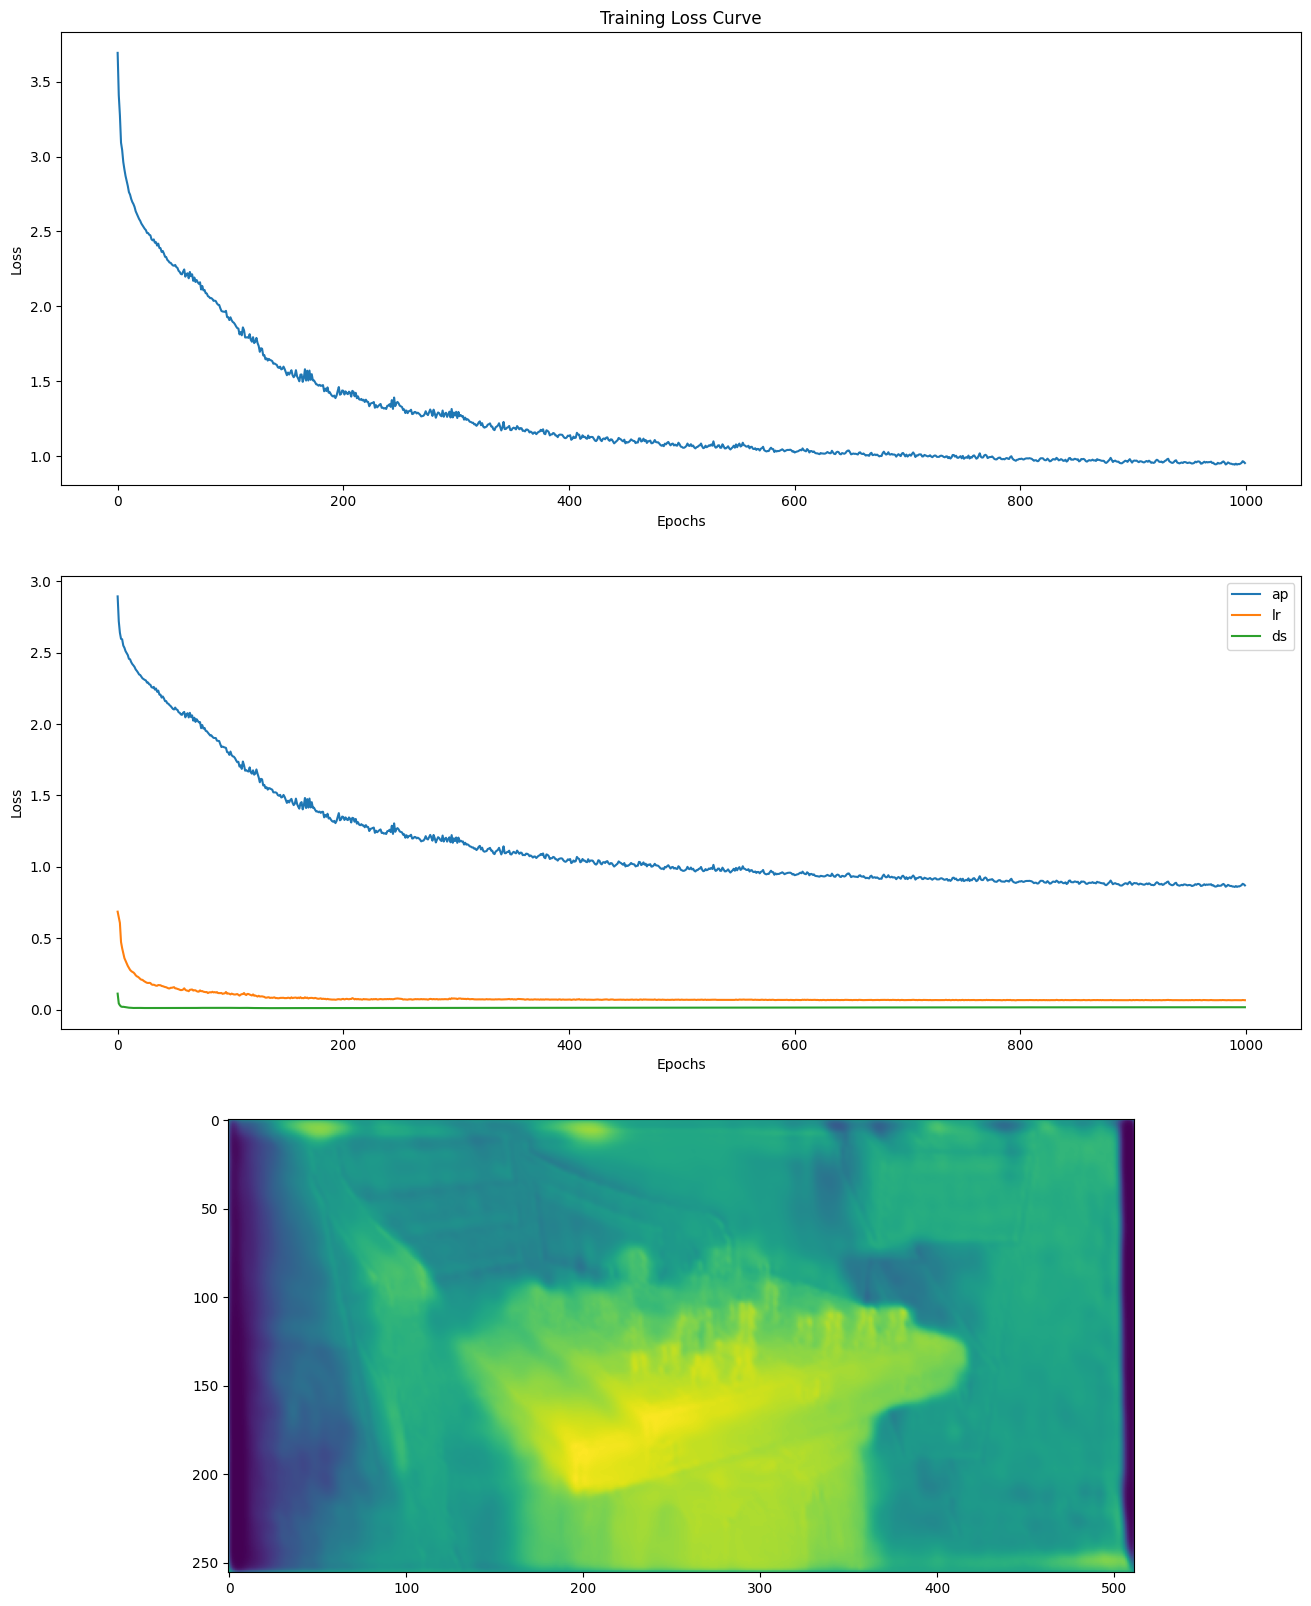

In [ ]:
# Plot the test results
%matplotlib inline
fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
dmap_plot = fig.add_subplot(3,1,3)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Curve')
ax.plot(test_net.loss_graph)
    
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(test_net.ap, label='ap')
ax2.plot(test_net.lr, label='lr')
ax2.plot(test_net.ds, label='ds')
ax2.legend(loc='upper right')

dmap = plotDispResults(test_net, test_dataset, 0, plot=False)
dmap_plot.clear()
dmap_plot.imshow(dmap[0,0])

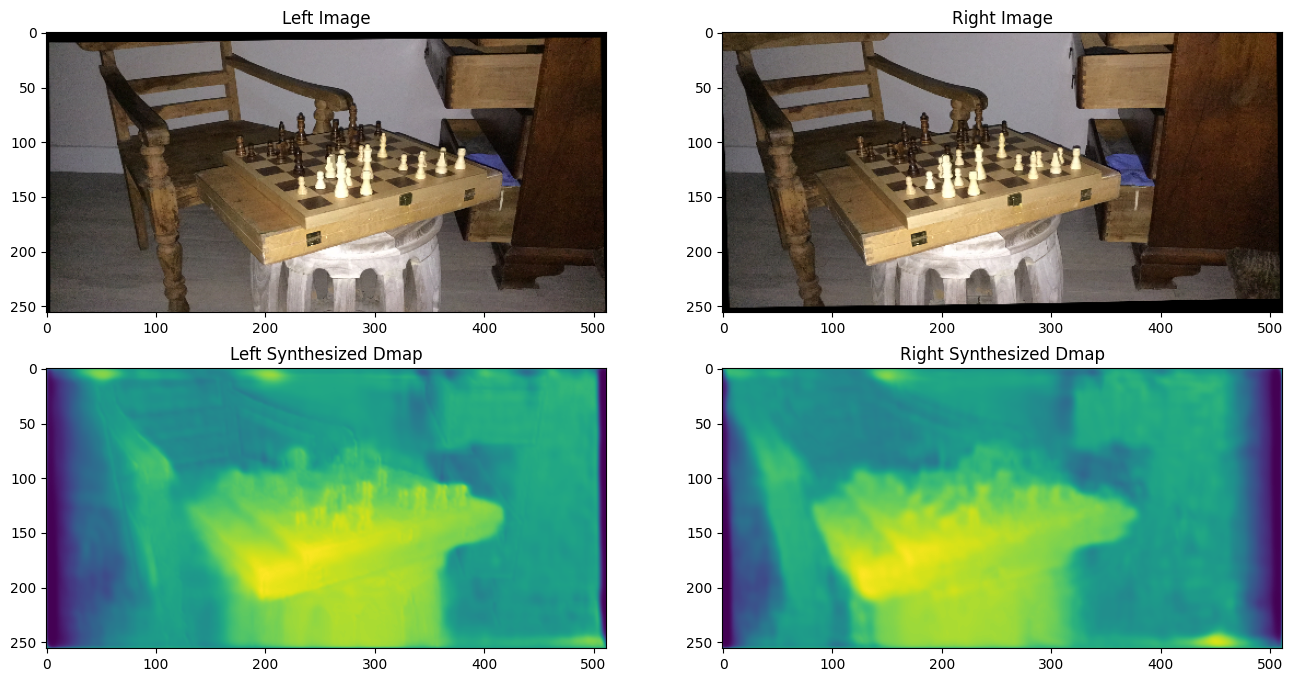

In [ ]:
dmap = plotDispResults(test_net, test_dataset, 0)

After training the model, the left and right disparity maps are both quite good where the chess set on the table is light green, which represents it is much closer to the camera than the darker green chair and the drawer. The background and the back of the chair are mixed between dark green and dark blue, which does not clearly show the distinction for the background's depths. The random artifacts at the top part of the chair and the bottom right corner of the disparity maps cannot be eliminated, and its cause is uncertain. One possibility is that the network was trapped in a local minimum due to the differences in the right image having a fuzzy texture in the bottom right corner and the top of the rocking chair where the left image didn't. Note: The final model was trained without using a GPU, so the training time is much longer than the fitting the single chess image for the test_net.

# Training the Model

The model gets trained on the 3318 images from train_loader.

In [ ]:
train_net = MyNet().to(device)
# train_net.load_state_dict(torch.load(WEIGHTS_DIR+"/train_weights2"))
# train_net.eval()

In [ ]:
%%time
loss_fcn = MonocularDepthLoss(device).to(device)
optimizer = torch.optim.Adam(train_net.parameters(), lr=0.01)
print("Starting Training with #images: ", len(train_loader) * train_loader.batch_size)
train_net.learn(train_loader, epochs=5, optimizer=optimizer, loss_fcn=loss_fcn)

Starting Training with #images:  3336


 20%|██        | 1/5 [03:30<14:03, 210.91s/it]

Epoch: 0 Loss: 2.349707841873169


 40%|████      | 2/5 [06:55<10:20, 206.96s/it]

Epoch: 1 Loss: 2.268582344055176


 60%|██████    | 3/5 [10:22<06:54, 207.30s/it]

Epoch: 2 Loss: 1.6769355535507202


 80%|████████  | 4/5 [13:54<03:29, 209.13s/it]

Epoch: 3 Loss: 1.2006303071975708


100%|██████████| 5/5 [17:20<00:00, 208.16s/it]

Epoch: 4 Loss: 1.7541000843048096
CPU times: user 5min 13s, sys: 20.4 s, total: 5min 33s
Wall time: 17min 20s


## Overfit/Diverging Model

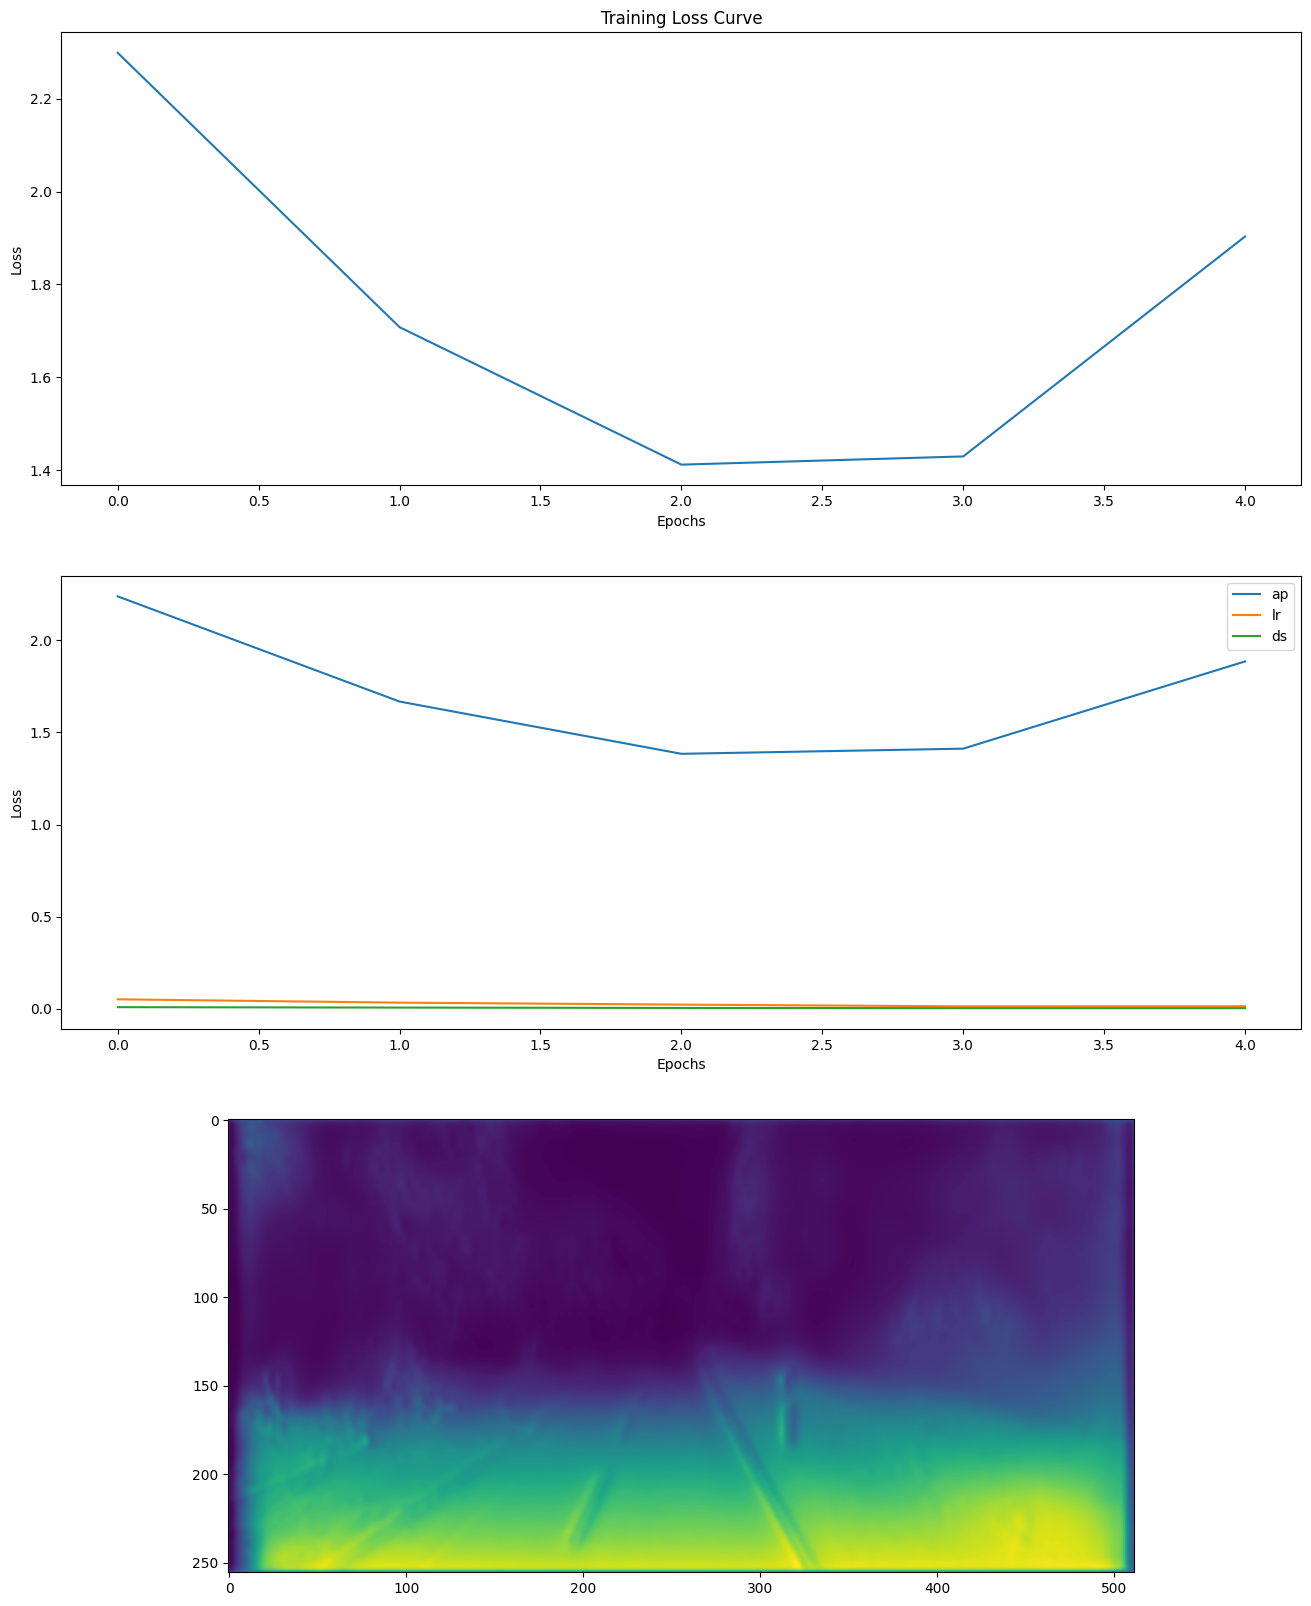

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
dmap_plot = fig.add_subplot(3,1,3)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Curve')
ax.plot(train_net.loss_graph)
    
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(train_net.ap, label='ap')
ax2.plot(train_net.lr, label='lr')
ax2.plot(train_net.ds, label='ds')
ax2.legend(loc='upper right')

dmap = plotDispResults(train_net, val_dataset, 10, plot=False)
dmap_plot.clear()
dmap_plot.imshow(dmap[0,0])

## Final Model

In [ ]:
# torch.save(train_net.state_dict(), WEIGHTS_DIR+"/train_weights2")

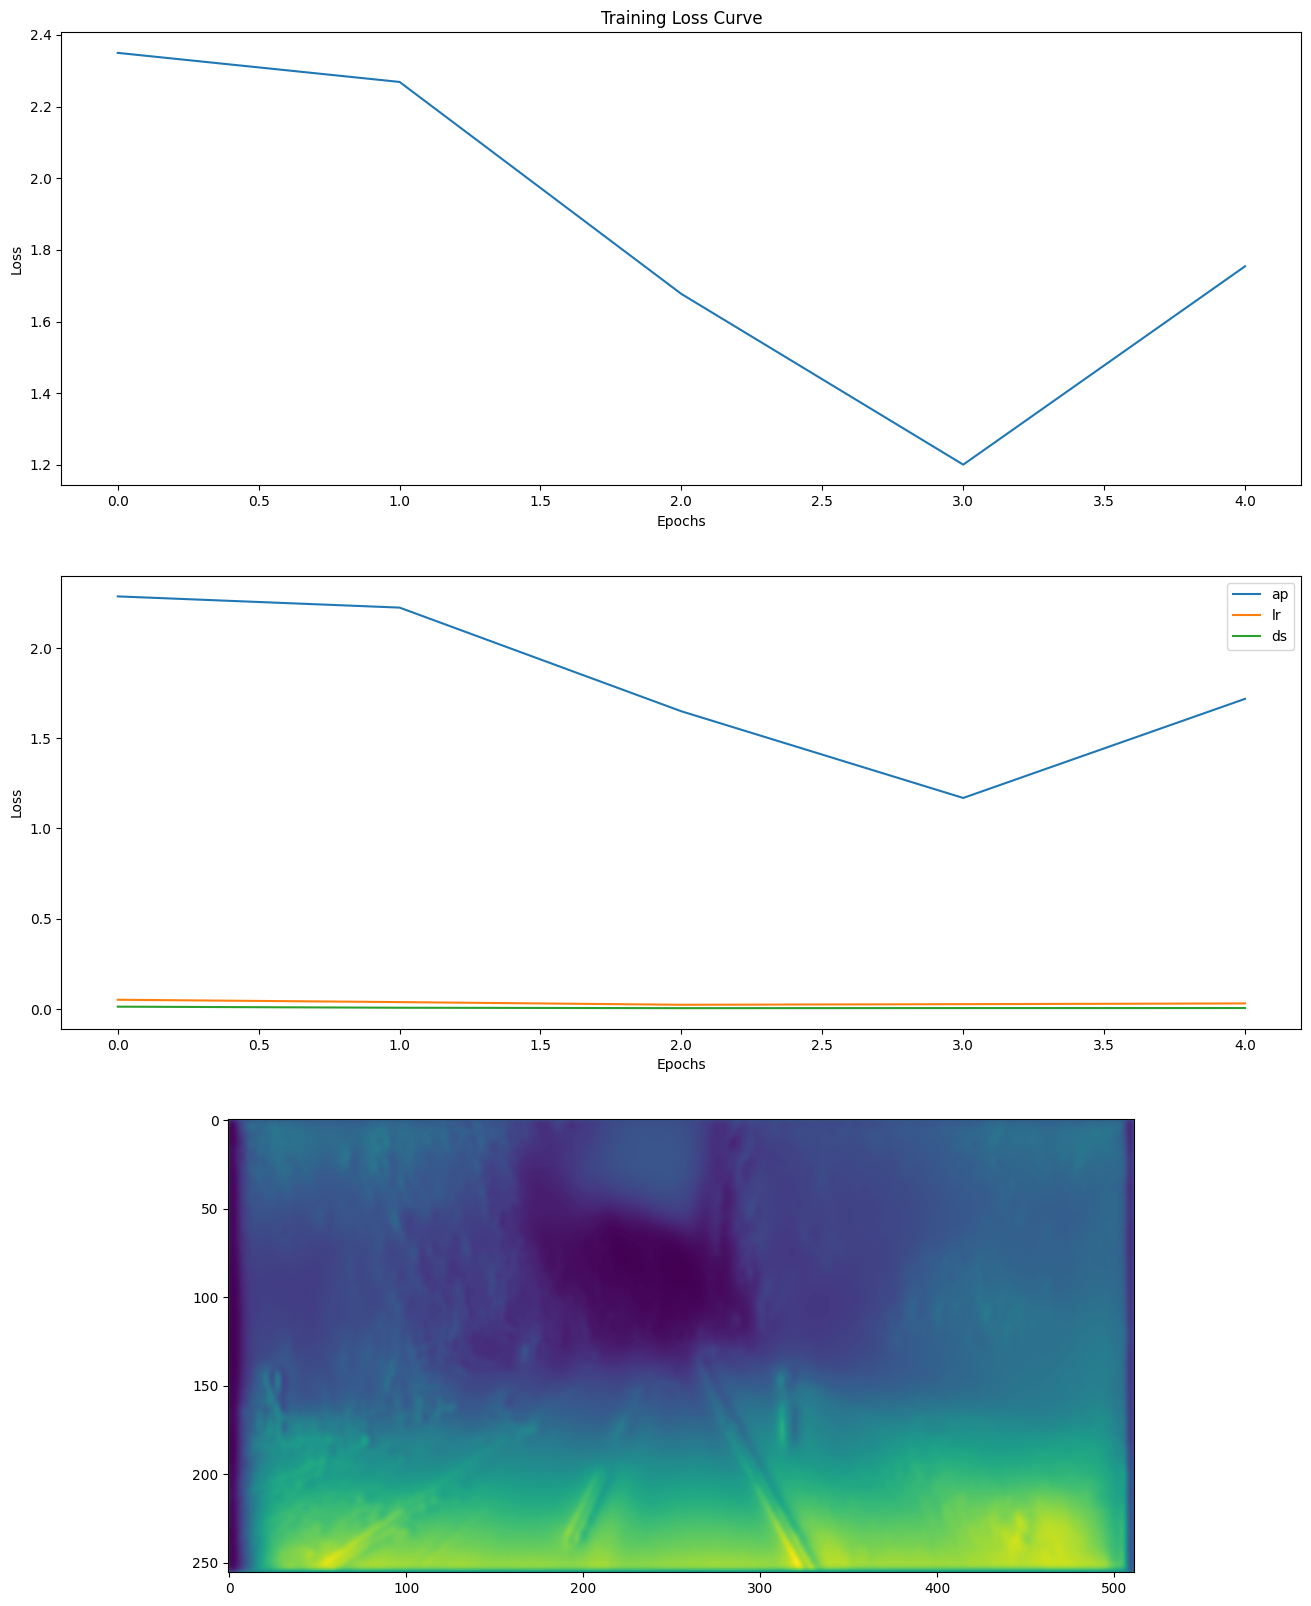

In [ ]:
# Plot the training results
%matplotlib inline
fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
dmap_plot = fig.add_subplot(3,1,3)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Curve')
ax.plot(train_net.loss_graph)
    
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(train_net.ap, label='ap')
ax2.plot(train_net.lr, label='lr')
ax2.plot(train_net.ds, label='ds')
ax2.legend(loc='upper right')

dmap = plotDispResults(train_net, val_dataset, 10, plot=False)
dmap_plot.clear()
dmap_plot.imshow(dmap[0,0])

# Cross Validation Loss

The network is validated using a random unseen left-right image pairs in  the val_loader. Calculating the cross-validation loss shows the robustness and generalizability of a model to prevent overfitting. Note that it uses the same loss function used during training.

In [ ]:
# Set model to evaluation mode
train_net.eval()

# Iterate through the validation dataloader
total_loss = 0
with torch.no_grad():
    for i, data in enumerate(val_loader):
        imL, imR = data
        imL = imL.to(device)
        imR = imR.to(device)
        
        output = train_net.forward(imL.to(device))
        loss = loss_fcn(output, [imL, imR])
        print(i, loss)
        total_loss += loss.item()
    
    # calculate average validation loss
    avg_val_loss = total_loss / len(val_loader)
    print(avg_val_loss)

0 tensor(1.2565, device='cuda:0')
1 tensor(1.2126, device='cuda:0')
2 tensor(1.2101, device='cuda:0')
3 tensor(1.2970, device='cuda:0')
4 tensor(1.3393, device='cuda:0')
5 tensor(1.2400, device='cuda:0')
6 tensor(1.2848, device='cuda:0')
7 tensor(1.3193, device='cuda:0')
8 tensor(1.2841, device='cuda:0')
9 tensor(1.2971, device='cuda:0')
10 tensor(1.2463, device='cuda:0')
11 tensor(1.2749, device='cuda:0')
12 tensor(1.3285, device='cuda:0')
13 tensor(1.3124, device='cuda:0')
14 tensor(1.3248, device='cuda:0')
15 tensor(1.3282, device='cuda:0')
16 tensor(1.2670, device='cuda:0')
17 tensor(1.2393, device='cuda:0')
18 tensor(1.3303, device='cuda:0')
19 tensor(1.2086, device='cuda:0')
20 tensor(1.3131, device='cuda:0')
21 tensor(1.2670, device='cuda:0')
22 tensor(1.3110, device='cuda:0')
23 tensor(1.2999, device='cuda:0')
24 tensor(1.2833, device='cuda:0')
25 tensor(1.3563, device='cuda:0')
26 tensor(1.2943, device='cuda:0')
27 tensor(1.2497, device='cuda:0')
1.2848565833909171


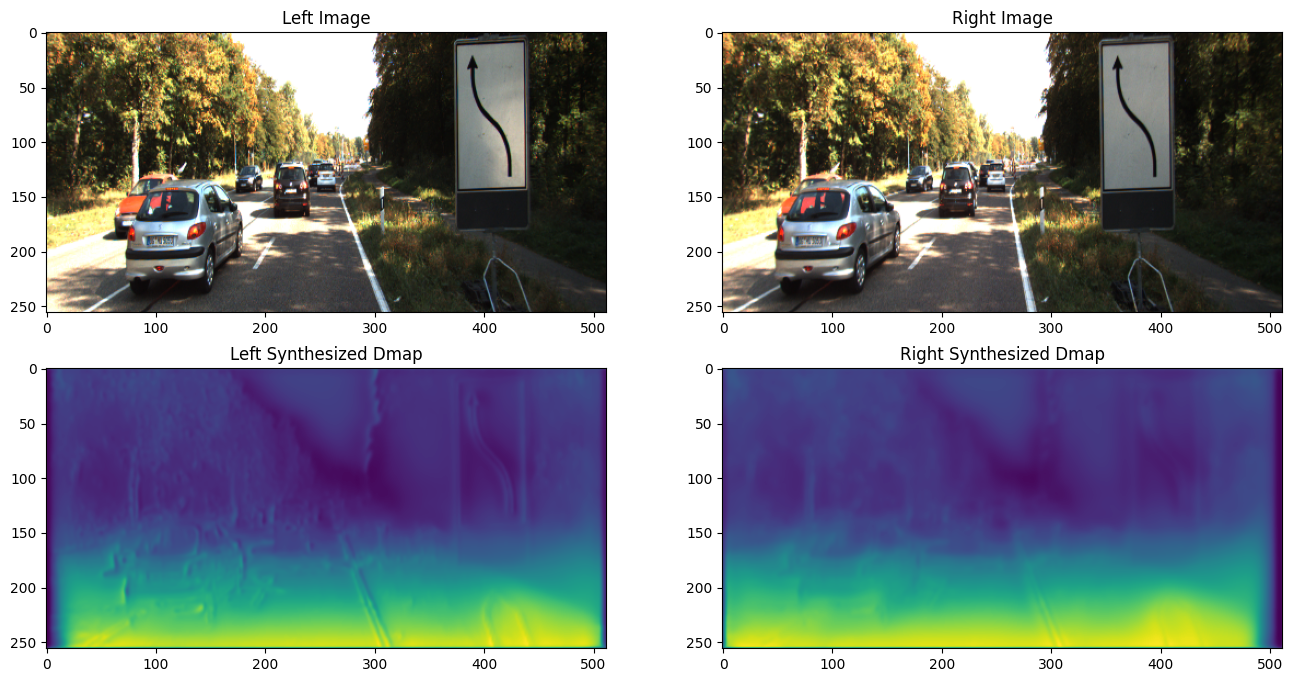

In [ ]:
dmap = plotDispResults(train_net, val_dataset, 300)

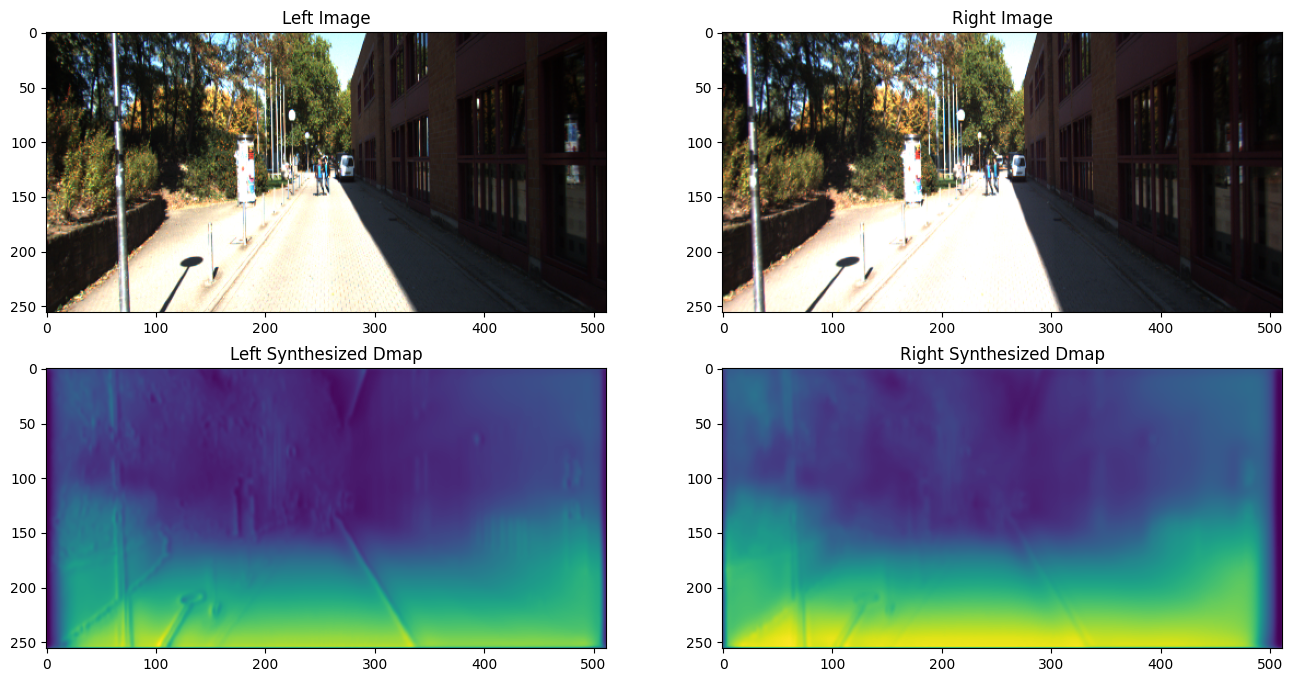

In [ ]:
dmap = plotDispResults(train_net, val_dataset, 350)

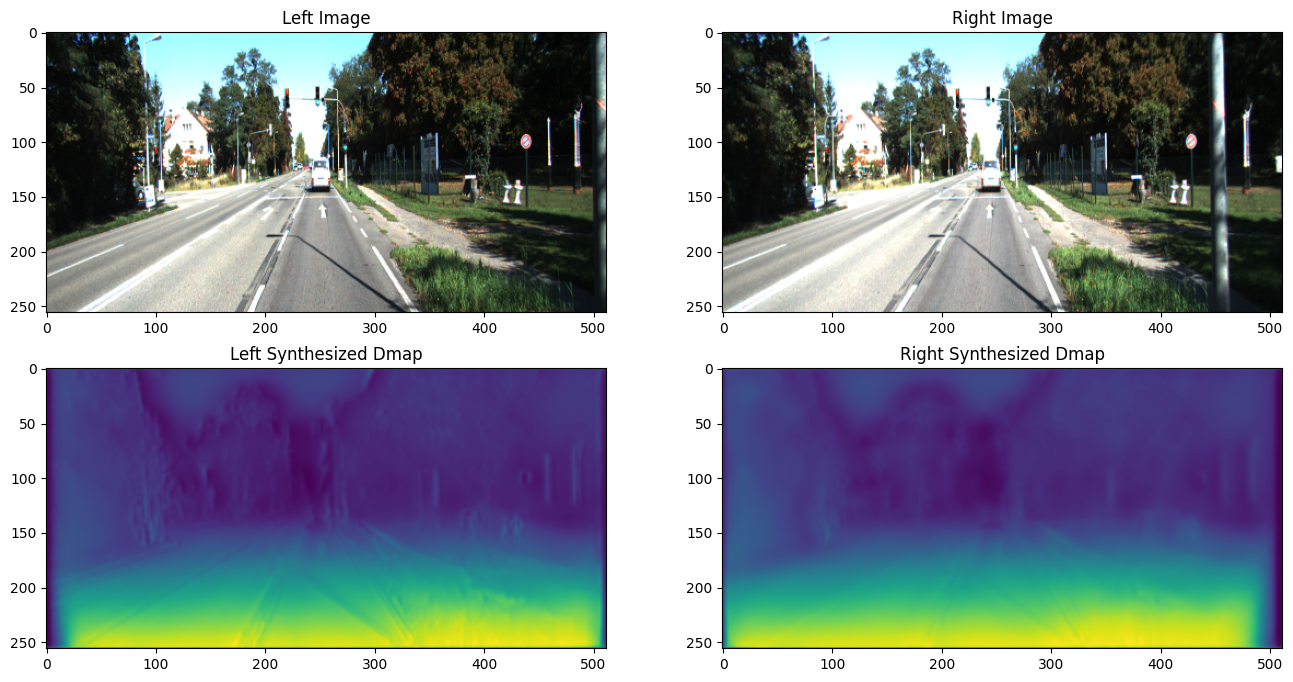

In [ ]:
dmap = plotDispResults(train_net, val_dataset, 600)

# Conclusion

The model performs well on the unseen validation data with an average cross-validation loss of 1.285 despite being trained on approximately 3000 training data for five epochs. The output shows closer areas are brighter yellow and green (higher disparity value), while farther objects near vanishing points are dark blue (lower disparity values).
The left-right consistency loss ensured that the left and right disparity maps were consistent, enabling the network to leverage information from both images while training. However, the left disparity map exhibited visible boundaries likely induced by the gradient smoothness loss function, while the edge boundaries were not visible on the right disparity map. The edge artifacts could imply that the gradient smoothness loss function reached two local minima, the correct right disparity map (without visible edge boundaries) and the incorrect left disparity map (with visible edge boundaries). The artifacts in the left disparity map could be removed by adding more unique dataset samples, decreasing the learning rate and reducing the regularization parameter $\alpha_{ds}$. The appearance matching loss does not converged to a low value, unlike the disparity smoothness and left-right consistency losses, resulting in a blurry disparity map that is not entirely accurate. A reccomendation for improvement is to have more left-right image pairs in the train_loader. The dark blue disparity bars on the left side of the left disparity map and the right side of the right disparity map are other limitations. These areas result from regions in the left image that are not present in the right image and vice versa, making the appearance loss function unusable for these regions. The post-processing solution by Godard et al. resolved this issue by running the model on both the input image and its reflection and then combining the two images to construct a disparity map without any disparity ramps.
<br><br>
From training the model, the loss stops improving after approximately 3-4 epochs as the loss reaches a minimum of about 1.2. However, training the model for ten epochs results in degradation in the depth map as it produces seemingly random garbage. A possible reason for this occurence lies in potential conceptual issues with the loss function and should get explored in the future. The model should also be training on more data. However, with limited storage of 15 GB of Google Drive space, a small learning rate, and limited computational resources of one Google Colab GPU, following the results from the paper to train the model is not practical. Other recommendations for the future include addressing challenges of the accuracy of depth estimation affected by occlusions, lighting conditions, and reflective surfaces. The estimated depth maps contained errors and artifacts, especially in areas with low texture or ambiguous features.
<br><br>
Overall, the self-supervised deep neural network for single image depth estimation that exploits binocular stereo data instead of aligned ground truth depth data. The model's loss function consists of photo-consistency comparison between predicted depth maps and disparity map regularization during training, leading to superior results compared to fully supervised baselines. The model can also generalize to unseen datasets and produce visually plausible depth maps. The authors suggest future work on extending the model to intake videos as the temporal consistency would improve results, investigating sparse input as an alternative training input, and predicting the full occupancy of the scene.

